## <center> *Модель прогнозирования стоимости жилья для агентства недвижимости*

Агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

**Наша цель** — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

# <center> **Часть I. Обработка данных.**

Здесь я буду проводить обработку данных, генерацию новых признаков и их очистку, пока без разведывательного анализа. Результат работы будет сохранен в отдельный датасет.

Импорт библиотек

In [55]:
# анализ данных
import pandas as pd
import numpy as np

# чтение словарных строк
import ast

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# технические функции
from functions import *

# игнорируем предупреждения
import warnings
warnings.filterwarnings('ignore')

# устанавливаем стиль графиков
plt.style.use('bmh')

## **Описательный анализ данных**

Читаем данные

In [56]:
data = pd.read_csv('data/data.csv')

display(data.head())
print(f'{data.shape[0]} rows, {data.shape[1]} columns')

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


377185 rows, 18 columns


Основная информация о данных

In [57]:
# функция из модуля functions (на мой взгляд дает больше информации 
# чем классические методы `.info()` или `.describe()`)
get_data_info(data)

,Nulls,Uniques,Dtypes
status,10.58,160,object
private pool,98.89,2,object
propertyType,9.21,1281,object
street,0.00,337077,object
baths,28.19,230,object
homeFacts,0.00,321009,object
fireplace,72.66,1653,object
city,0.01,2027,object
schools,0.00,297365,object
sqft,10.76,25406,object


> Все данные здесь относятся к типу `object`. Во многих столбцах количество пропусков доходит до 90 процентов и выше. Значит еобходимо провести их **очистку**. 

In [58]:
# Соединяем столбцы с ID сделки, так как в одном из них 
# может содержаться информация, отсутствующая в другом.
data['MlsId'] = data['MlsId'].fillna('') + data['mls-id'].fillna('')
data['MlsId'] = data['MlsId'].apply(lambda x: np.nan if x == '' else x)


# Удалим из данных те строки и столбцы, которые содержат более 70% пропусков
t_col = data.shape[0] * 0.7
data.dropna(axis=1, thresh=t_col, inplace=True)

t_row = data.shape[1] * 0.7
data.dropna(axis=0, thresh=t_row, inplace=True)


# Обновим индексацию для удобства
data.reset_index(drop=True, inplace=True)

get_data_info(data)

,Nulls,Uniques,Dtypes
status,10.18,159,object
propertyType,5.13,1281,object
street,0.00,321390,object
baths,24.81,230,object
homeFacts,0.00,317304,object
city,0.01,2000,object
schools,0.00,286152,object
sqft,6.62,25397,object
zipcode,0.00,4499,object
beds,21.57,193,object


> Теперь данных стало намного меньше, но из них можно выделить много информации. Проведем обработку признаков.

## **Обработка признаков**

Алгоритм, с помощью которго я буду обрабатывать данные примерно один и тот же:

1. Смотрим на значения в признаке, для удобства - самые часто встречающиеся
2. Очищаем их от ошибок ввода и ненужных символов 
3. Визуально выделяем повторяющиеся категории
4. Создаем бинарные признаки по самым популярным категориям. Если признак содержит числа, создаем числовой
5. Если значение не попадает ни в одну категорию, создаем для него признак "other". 
6. Также создаем признак, указывающий, был ли пропуск на его месте, или присваиваем ему значение -1.
6. Заносим получившиеся признаки в новую таблицу

In [59]:
# Я создал новую таблицу, чтобы заносить туда уже готовые обработанные признаки, 
# и которую я и буду в последствии использовать для Разведывательного анализа и Машинного обучения
better_data = pd.DataFrame(index=data.index)

better_data

""
0
1
2
3
4
...
360187
360188
360189
360190


### Статус продажи

Продавец может указывать разную цену в зависимости от формата сделки. Если жилье сдается в аренду, то указывается цена за месяц аренды. А если недвижимость ушла от покупателя к продавцу из-за невыплаты ипотеки, значит цена была очень высока. 

In [60]:
def fix_feature(feature, 
                filling='Unknown',
                lower=True):
    """
    Функция заполняет пропуски и приводит значения 
    признака к нижнему регистру, тем самым упрощая анализ.
    
    - feature: название признака
    - filling: заполняющее значение ('Unknown')
    - lower: нужно ли приводить значения к нижнему регистру (да)
    """
    
    x = feature.fillna(str(filling))
    
    if lower:
        x = x.apply(lambda x: x.lower())
    
    return x


# Упростим задачу, заполнив оставшиеся пропуски 
# и приведя все значения к нижнему регистру
for col in data.columns:
    data[col] = fix_feature(data[col])

In [61]:
# функция из модуля functions 
get_populars(data['status'])

['for sale',
 'active',
 'unknown',
 'foreclosure',
 'new construction',
 'pending',
 'pre-foreclosure',
 'p',
 'pre-foreclosure / auction',
 'under contract show',
 ' / auction',
 'under contract   showing',
 'active under contract',
 'under contract',
 'new',
 'contingent',
 'price change',
 'auction',
 'a active',
 'for rent',
 'foreclosed',
 'under contract backups',
 'contingent finance and inspection',
 'recently sold',
 'pending continue to show',
 'option pending',
 'back on market',
 'contingent show',
 'pending taking backups',
 'option contract',
 'active with offer',
 'pending with contingencies',
 'active backup',
 'c',
 'contract p',
 'pi',
 'p pending sale',
 'listing extended',
 'auction - active',
 'due diligence period',
 'contract contingent on buyer sale',
 'c continue show',
 'pending - taking backups',
 'offer pending signature',
 'active/contingent',
 'pending inspection',
 'contingent take backup',
 'contingent   show',
 'pending in',
 'active with contingencies

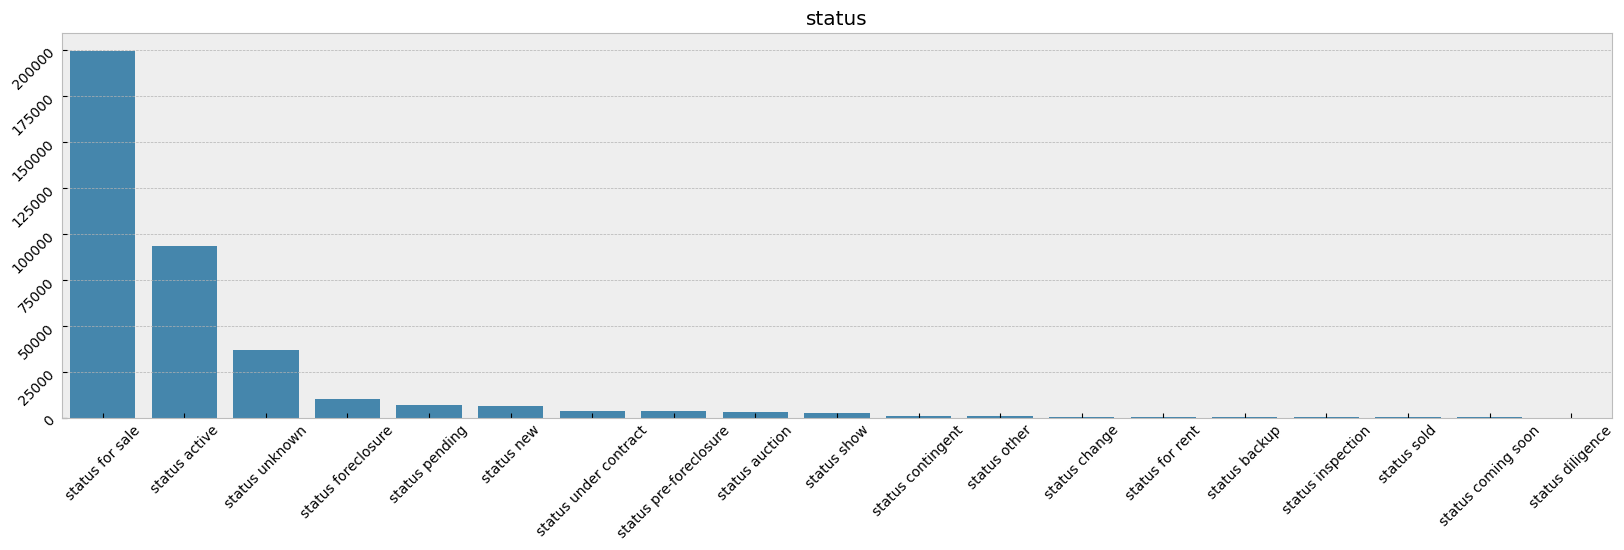

In [62]:
# создадим 2 очень полезные функции для создания признаков и выведения графика по ним

def get_dummy_features(f_name, 
                       rep_dict=None, 
                       labels=None, 
                       data=data, 
                       new_data=better_data,
                       get_replaced=False):
    """
    Функция создает бинарные переменные для категориальных признаков.
    
    - f_name: название признака
    - rep_dict: словарь с синонимами для replace()
    - labels: список из самых популярных категорий в признаке
    - data: основная таблица
    - new_data: таблица, в которую добавляются созданные признаки
    - get_replaced: вернуть ли только обработанный признак из data? 
    """
    
    # признак
    feature = data[f_name]
    
    # заменяем ненужные слова и синонимы
    if rep_dict is not None:
        for key, val in rep_dict.items():
            feature = feature.apply(lambda x: x.replace(key, val))
    
    # если нужно посмотреть, как обработался признак
    if get_replaced:
        return feature
    
    # в новой таблице создаем признаки с названием в формате "имя_признака категория" 
    # если в значении изначального признака встречается категория из списка labels - 
    # возвращается 1, и если нет - 0.
    if labels is not None:
        for label in labels:
            new_data[f_name+' '+label] = data[f_name].apply(lambda x: 1 
                                                            if label in x 
                                                            else 0)
        
        # выделяем колонки, где есть f_name
        named_cols = list(filter(lambda x: f_name in x, new_data.columns))
        
        # создаем признак для значений, не попавших ни в одну категорию
        new_data[f_name+' other'] = (new_data.loc[:, named_cols]
                                    .sum(axis=1)
                                    .apply(lambda x: 1 if x == 0 else 0))
    
    return new_data 


def show_barplot(col, 
                 data=better_data, 
                 figsize=(20, 5), 
                 is_binary=True, 
                 rotation=45):
    """
    Показывает столбчатую диаграмму для бинарных и числовых признаков.
    
    - col: название стобца или слово которое встречается в нескольких стобцах
    - data: таблица с данными
    - figsize: размер графика
    - is_binary: если признаки бинарные, используются суммы по столбцам,
        если один числовой - используется метод .value_counts()
    - rotation: на сколько градусов повернуть названия на графике
    """
    
    # функции из модуля functions
    if is_binary:
        values = get_sums(data, col).sort_values(ascending=False)
    else:
        values = get_vc(data[col])
        rotation = 0 # поворачивать названия не нужно
    
    # рисуем график
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(values, ax=ax)
    
    # настраиваем параметры графика
    ax.tick_params(rotation=rotation)
    ax.set_xlabel('')
    ax.set_title(col)
    
    return fig.show()


# словарь, где ключ - слово, которое нужно заменить, 
# а значение - слово, которым заменяют
status_dict = {'forclosed': 'forclosure', 
               'pre forclosure': 'pre-forclosure', 
               'c': 'contingency', 
               'contingency': 'contingencies', 
               'contingencies': 'contingent'}

# список самых часто встречающихся категорий
statuses = ['for sale', 'coming soon', 'new', 
            'foreclosure', 'pre-foreclosure', 'pending', 
            'auction', 'active', 'show',  
            'for rent', 'sold', 'under contract', 
            'contingent', 'change', 'unknown', 
            'backup', 'inspection', 'diligence']

# я подозреваю, что "р" в данных - это просто сокращение слова "pending", 
# так что решил его заменить
data['status'] = (data['status']
                  .apply(lambda x: 'pending' 
                         if ((x == 'p') or 
                             (len(x) == 2 and 'p' in x)) 
                         else x))

# применяем нашу функцию 
better_data = get_dummy_features('status', status_dict, statuses)

# выводим график
show_barplot('status')

> Большинство продавцов выставляют недвижимость на продажу, объявления еще активны, а часть имеет неизвестный статус.

**Примечание.** В дальнейшем комментарии указывать буду только по крайней необходимости, так как алгоритм повторяющийся. 

### Тип недвижимости

Очевидно, что цена очень зависит от того, продается ли квартира, дом, участок или кондоминиум, а также, в каком стиле выполнено здание, на кого рассчитано и так далее.

In [63]:
get_populars(data['propertyType'])

['single-family home',
 'single family',
 'condo',
 'single family home',
 'lot/land',
 'unknown',
 'townhouse',
 'land',
 'multi-family',
 'condo/townhome/row home/co-op',
 'traditional',
 'coop',
 'multi family',
 'high rise',
 'ranch',
 'mobile/manufactured',
 'detached, one story',
 'single detached, traditional',
 'contemporary',
 'multi-family home',
 '1 story',
 'colonial',
 'mobile / manufactured',
 'contemporary/modern',
 '2 stories',
 'apartment',
 'mfd/mobile home',
 'single detached',
 'detached, two story',
 'one story',
 'transitional',
 'cooperative',
 'florida',
 'bungalow',
 'farms/ranches',
 'two story',
 'garden home',
 '2 story',
 'cape cod',
 '2 stories, traditional',
 'spanish/mediterranean',
 'other style',
 '1 story, traditional',
 'other',
 'condo/townhome, traditional',
 'craftsman',
 'contemporary/modern, traditional',
 'condo/townhome',
 'singlefamilyresidence',
 'condo/townhome, contemporary/modern',
 'single detached, contemporary/modern',
 'multiple occup

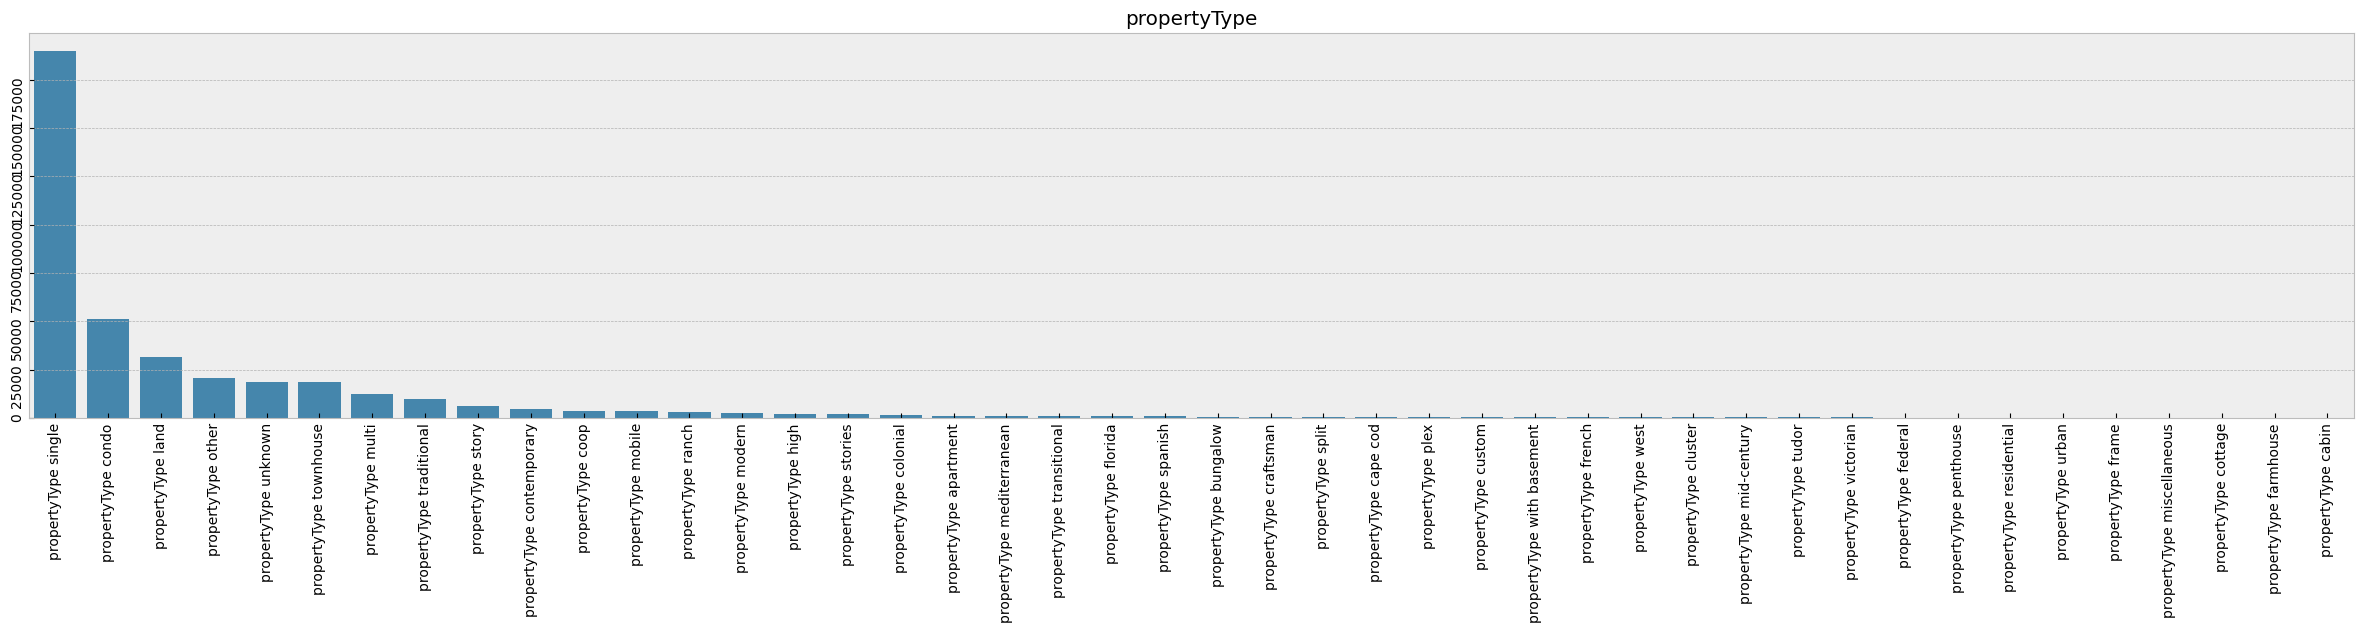

In [64]:
propdict = {'tiny': 'single', 
            'detached': 'single',  
            'co-op': 'coop', 
            'townhome': 'townhouse', 
            'manufactured': 'prefab', 
            'prefab': 'mo2 le',
            'mo2 le': 'mo2le',
            'modular': 'mobile', 
            'mo2le': 'mobile',
            'ca 2n': 'ca2n', 
            'ca2n': 'cabin', 
            'other': ''} 

proptypes = ['single', 'condo', 'land', 'townhouse', 'multi', 
             'coop', 'traditional', 'ranch', 'mobile', 'contemporary', 
             'modern', 'apartment', 'story', 'stories', 'high', 
             'colonial', 'mediterranean', 'cape cod', 'cottage', 'craftsman', 
             'transitional', 'custom', 'cluster', 'federal', 'urban', 
             'split', 'victorian', 'farmhouse', 'with basement', 'french', 
             'spanish', 'mid-century', 'tudor',  'federal', 'residential', 
             'miscellaneous', 'bungalow', 'florida', 'frame', 'west', 
             'penthouse', 'plex', 'cabin']

better_data = get_dummy_features('propertyType', 
                                 rep_dict=propdict, 
                                 labels=proptypes)

# если на месте значения был пропуск, это надо указать
better_data['propertyType unknown'] = (data['propertyType']
                                       .apply(lambda x: 1 
                                              if x in ('unknown', ' ') 
                                              else 0))


show_barplot('propertyType', figsize=(30, 5), rotation=90)

> Большинство объектов в данных являются односемейными домами. Далее по популярности идут кондоминиумы, участки, таунхаусы, многосемейные, и дома в традиционном стиле. 

### Количество ванных

Количество ванных вероятно коррелирует с площадью недвижимости, а это прямо пропорционально связано с ценой на нее.

In [65]:
get_populars(data['baths'])

['unknown',
 '2 baths',
 '3 baths',
 '2',
 '2.0',
 '4 baths',
 '3.0',
 '3',
 'bathrooms: 2',
 '2.5',
 'bathrooms: 3',
 '1',
 '1.0',
 '5 baths',
 '4.0',
 '2.5 baths',
 '0',
 '4',
 '3.5',
 'bathrooms: 1',
 '2 ba',
 '6 baths',
 'bathrooms: 4',
 '1,500',
 '3 ba',
 '1.5',
 '3.5 baths',
 '2,000',
 '1,750',
 '3,000',
 '5.0',
 '2,250',
 '1,000',
 '5',
 '7 baths',
 '1,250',
 '4.5',
 '2,750',
 '2,500',
 'bathrooms: 5',
 '~',
 '1 ba',
 '6.0',
 '4 ba',
 '3,500',
 '8 baths',
 '-- baths',
 '6',
 '4.5 baths',
 '7.0',
 'bathrooms: 6',
 '9 baths',
 '5.5',
 '7',
 '4,000',
 '5 ba',
 '2.5+',
 '1.5 baths',
 '750',
 '5,000',
 '8.0',
 '3.5+',
 'sq. ft. ',
 '10 baths',
 '8',
 '4.5+',
 'bathrooms: 7',
 '5.5+',
 '6.5',
 '9.0',
 '6 ba',
 '11 baths',
 '1.75 baths',
 'bathrooms: 8',
 '5.5 baths',
 '12 baths',
 '9',
 '0 / 0',
 '6.5+',
 '7 ba',
 '1.5+',
 '10.0',
 '10',
 '2.1 baths',
 '2.5 ba',
 '13 baths',
 '11',
 '8 ba',
 '2.75 baths',
 'bathrooms: 9',
 '16 baths',
 '7.5',
 '7.5+',
 '11.0',
 '14 baths',
 'bathrooms

> В этом признаке присутствует несколько разных форматов. Либо количество указывается перед словом ("2 baths", "3 ba"), либо после него ("bathrooms: 4"), нужно просто выделить цифру. Значения с точкой или с плюсом будем считать ошибкой ввода и просто выделим первую цифру. Иногда вместо количества ванн вводят, по видимому площадь - это будут пропуски. 

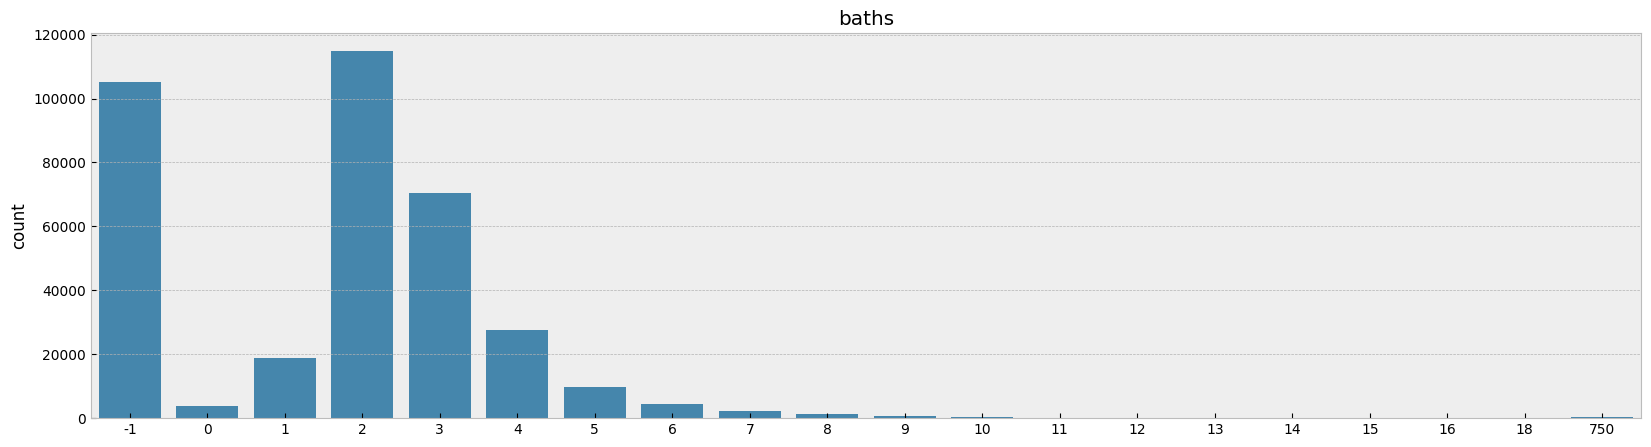

In [66]:
def get_baths(x):   
    """ 
    Выделяет количество ванн.
    """ 
    # если это значение с точкой - берем просто первую цифру
    if '.' in x:
        x = x.split('.')[0]
    
    # если в значении присутствует слэш или тире - также берем первую цифру
    if '/' in x:
        x = x.split(' / ')[0]
        
        if '-' in x:
            x = x.split('-')[0]

    # после всего, если значение не является числовым или содержит запятую - это пропуск
    if (not x.isnumeric()) or (',' in x):
        return -1
    else:
        return x


bath_dict = {' baths': ' ba',
             ' ba': '',  
             'bathrooms: ': '', 
             '.0': '', 
             '+': ''}

# поскольку нам нужно выделить только число, 
# функция `get_dummy_features` возвращает только обработанный столбец
better_data['baths'] = (get_dummy_features('baths', 
                                           bath_dict, 
                                           get_replaced=True)
                        .apply(get_baths)
                        .astype(int))


show_barplot('baths', is_binary=False)

> Дома имеют чаще всего 2-3 ванны. Также наблюдаются и выбросы вроде 750 ванн.

### Количество спален

Признак имеет то же значение, что и количество ванн.

In [67]:
get_populars(data['beds'])

['unknown',
 '3 beds',
 '4 beds',
 '3',
 '2 beds',
 '4',
 '2',
 'baths',
 '3 bd',
 '5 beds',
 '4 bd',
 '3.0',
 '5',
 '4.0',
 '2 bd',
 '1',
 '6 beds',
 '5 bd',
 '2.0',
 '6',
 '5.0',
 '0',
 '7 beds',
 '1 bd',
 '-- bd',
 '8 beds',
 'bath',
 '6 bd',
 '7',
 '1.0',
 '9 beds',
 ' ',
 '8',
 '6.0',
 '0.0',
 '10 beds',
 '7 bd',
 '12 beds',
 '8 bd',
 '9',
 '11 beds',
 '7.0',
 '10',
 '64 beds',
 '16 beds',
 '8.0',
 '11',
 '9 bd',
 '12',
 '13 beds',
 '14 beds',
 '18 beds',
 '10 bd',
 '15 beds',
 '16',
 '12 bd',
 '24 beds',
 '14',
 '13',
 '20 beds',
 '10.0',
 '24',
 '11 bd',
 '15',
 '20',
 '9.0',
 '17 beds',
 '18',
 '32 beds',
 '28 beds',
 '16 bd',
 '22 beds',
 '26 beds',
 '24 bd',
 '13 bd',
 '34 beds',
 '21 beds',
 '19 beds',
 '14 bd',
 '17',
 '28',
 '8,276 sqft',
 '36 beds',
 '11.0',
 '22',
 '25 beds',
 '23 beds',
 '32',
 '5,227 sqft',
 '16.0',
 '42 beds',
 '18 bd',
 '15.0',
 '29',
 '12.0',
 '44 beds',
 '47 beds',
 '40 beds',
 '34',
 '40']

> В целом признак по форматам очень похож на признак с ваннами. Иногда в этом признаке ошибочно указывают площадь недвижимости в квадратных футах или акрах. Будем считать их пропусками, как и другие нечисловые значения. 

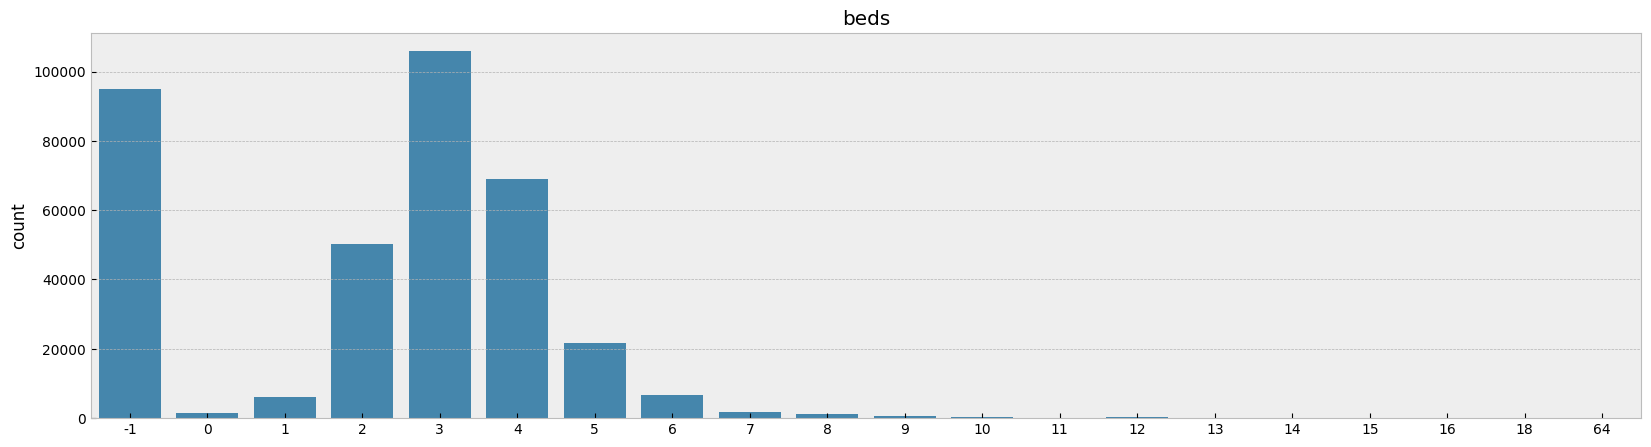

In [68]:
def get_beds(x):
    """
    Выделяет количество спален
    """
    # разделим значение по пробелам
    xsplit = x.split()
    
    # если в значении присутствуют эти слова - это пропуск
    exepts = ['unknown', 'sqft', 'acre', '-', '#']
    
    for ex in exepts:
        if ex in x:
            return -1
    
    # также если в значении есть решетка, оно имеет нулевую длину 
    # или содержит единственное слово "ванна" - это тоже пропуск
    if (('#' in xsplit) or
        (len(xsplit) == 0) or 
        ((len(xsplit) == 1) and ('bath' in xsplit[0]))):
        return -1
    
    # значение может иметь структуру "число or more bedrooms" - вычленяем число
    for i in range(len(xsplit)):
        if (xsplit[i] == 'or') or ('bedrooms' in xsplit[i]):
            return xsplit[i-1]
    
    if not xsplit[0].isnumeric():
        return -1
    else:    
        return x


beds_dict = {' beds': ' bd', 
             ' bd': '', 
             '+': '', 
             '.0': ''}

better_data['beds'] = (get_dummy_features('beds', 
                                          beds_dict, 
                                          get_replaced=True)
                       .apply(get_beds)
                       .astype(int))


show_barplot('beds', is_binary=False)

> В домах чаще всего находится от 2 до 4 спален, иногда - 64.

### Площадь недвижимости

In [69]:
data['sqft'].value_counts(dropna=False)[-100:].index.tolist()

['total interior livable area: 4,881 sqft',
 '1,916,640 sqft',
 'total interior livable area: 3,585 sqft',
 'total interior livable area: 5,012 sqft',
 '12,426 sqft',
 '60,692 sqft',
 '6,871 sqft',
 'total interior livable area: 5,793 sqft',
 '5029',
 '7,689 sqft',
 '155,155 sqft',
 '6,072 sqft',
 '5568',
 '9,093',
 '7,417',
 '13,461 sqft',
 '52,708',
 '17,181 sqft',
 '4782',
 '9,807 sqft',
 '5,472 sqft',
 'total interior livable area: 6,784 sqft',
 'total interior livable area: 6,842 sqft',
 '163,080 sqft',
 '6650',
 '31,927 sqft',
 '8262',
 '6,009 sqft',
 '7,471',
 '6435',
 '10,544 sqft',
 '5093',
 '7,750 sqft',
 '7,254',
 '6,792 sqft',
 '47,272 sqft',
 '107,988 sqft',
 '10,268 sqft',
 '6,112 sqft',
 '256,750 sqft',
 'total interior livable area: 3,900 sqft',
 'total interior livable area: 7,328 sqft',
 'total interior livable area: 3,551 sqft',
 '12,031 sqft',
 '7240',
 'total interior livable area: 5,409 sqft',
 '9,722',
 '5,938',
 '5724',
 '7,131',
 '4433',
 '21,360',
 '11,392',
 

> Я решил вывести последние 100 значений, так как в первых 100 указаны не все форматы. Чаще всего площадь указана в формате "число sqft", но иногда встречается также "total interior livable area: число". 

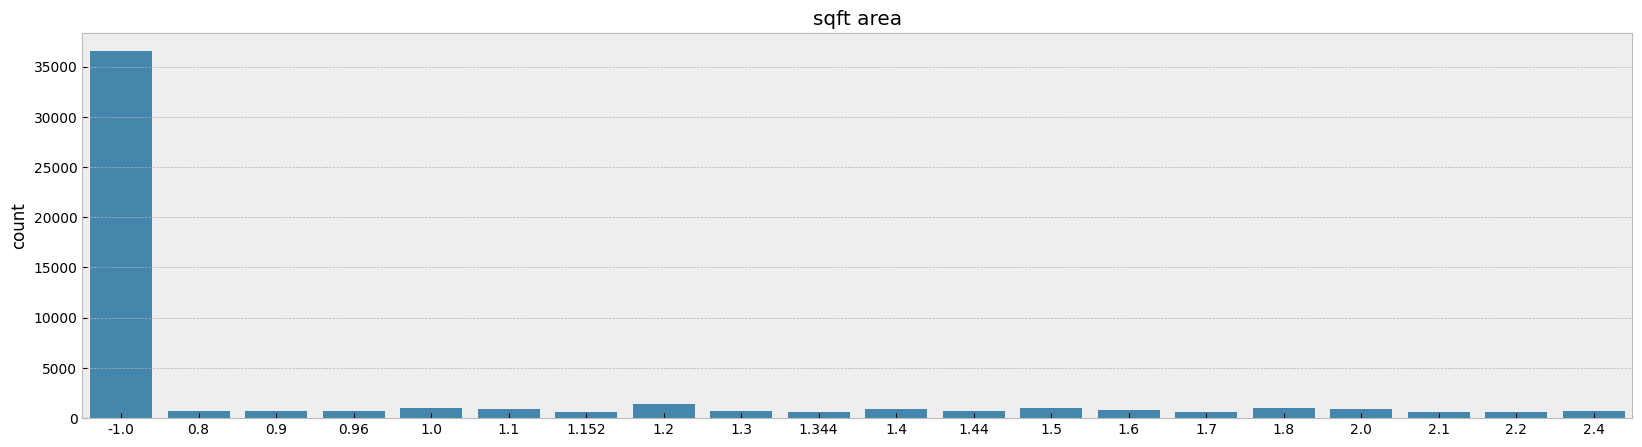

In [70]:
def get_sqft_area(x):
    """ 
    Выделяет площадь в квадратных футах.
    """
    
    # заменяем запятую, которая нам ни к чему и выделяем число
    xsplit = x.replace(',', '').split()
    q = xsplit[0]
    
    # если в значении есть слово "total" - информация находится во втором слове с конца
    if q == 'total':
        return xsplit[-2]
    
    if not q.isnumeric():
        return '-1'
    else:
        return q

# делим получившиеся значения на 1000 для удобства (своего рода масштабирование)
better_data['sqft area'] = (data['sqft']
                            .apply(get_sqft_area)
                            .astype(float)
                            .apply(lambda x: -1 if x == 0 else x)
                            .apply(lambda x: x / 1000 if x > 0 else x))


show_barplot('sqft area', is_binary=False)

> Конкретного закона или распределения здесь выявить нельзя, можно только обратить внимание, что в данных очень много пропусков. Но будем надеяться, что остальные значения в сумме перевесят их. 

### Факты о недвижимости

Данный признак представляет собой массив из словарей, преобразованных в строки. В них можно найти много полезной информациии. Примечательно, но эти данные **не являются** JSON-строками, так как используют одинарные кавычки, поэтому прочитать их с помощью модуля `json` невозможно.

In [71]:
data['homeFacts'] 

0         {'ataglancefacts': [{'factvalue': '2019', 'fac...
1         {'ataglancefacts': [{'factvalue': '2019', 'fac...
2         {'ataglancefacts': [{'factvalue': '1961', 'fac...
3         {'ataglancefacts': [{'factvalue': '2006', 'fac...
4         {'ataglancefacts': [{'factvalue': '', 'factlab...
                                ...                        
360187    {'ataglancefacts': [{'factvalue': '2010', 'fac...
360188    {'ataglancefacts': [{'factvalue': '1990', 'fac...
360189    {'ataglancefacts': [{'factvalue': '1924', 'fac...
360190    {'ataglancefacts': [{'factvalue': '1950', 'fac...
360191    {'ataglancefacts': [{'factvalue': '2019', 'fac...
Name: homeFacts, Length: 360192, dtype: object

In [72]:
# приведем пропуски к единому стандарту, для удобства
homefacts = (data['homeFacts'].apply(lambda x: x
                                     .replace("'', ", "'no data', ")
                                     .replace(": none", ": 'no data'")))

# для чтения строк-словарей используем стандартную библиотеку `ast`
# добавляем в список словари без ключа 'ataglancefacts', так как он единственный и неинформативный
hf_list_raw = []

for fact in homefacts:
    hf_le = ast.literal_eval(fact)
    hf_list_raw.append(hf_le['ataglancefacts'])


# в получившихся словарях информация находится под ключами: "factvalue" и "factlabel",
# поэтому выделяем только значения словарей и делаем из них новые словари, 
# где второе - ключ, а первое - значение, и добавляем в новый список.
hf_list = []

for flist in hf_list_raw:
    hf_dict = {}
    
    for fdict in flist:
        v_list = list(fdict.values())
        
        hf_dict[v_list[1]] = v_list[0]
    
    hf_list.append(hf_dict)
    

# из получившегося списка мы легко делаем таблицу DF
hf_df = pd.DataFrame(hf_list)

# для подсчета пропусков с помощью `get_data_info`, заменяем все на NaN
for col in hf_df.columns:
    hf_df[col] = (fix_feature(hf_df[col], filling='no data')
                  .apply(lambda x: np.nan if x == 'no data' else x))


display(hf_df)
display(get_data_info(hf_df))

,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft
0,2019,NaN,"central a/c, heat pump",NaN,NaN,NaN,$144
1,2019,NaN,NaN,NaN,NaN,5828 sqft,$159/sqft
2,1961,1967,forced air,central,attached garage,"8,626 sqft",$965/sqft
3,2006,2006,forced air,central,detached garage,"8,220 sqft",$371/sqft
4,NaN,NaN,NaN,NaN,NaN,"10,019 sqft",NaN
...,...,...,...,...,...,...,...
360187,2010,NaN,forced air,central,1 space,NaN,$564
360188,1990,1990,other,central,2 spaces,"8,500 sqft",$311
360189,1924,NaN,radiant,NaN,none,NaN,$337/sqft
360190,1950,1950,other,NaN,2,"1,600 sqft",$458/sqft


,Nulls,Uniques,Dtypes
year built,13.45,229,object
remodeled year,58.47,152,object
heating,28.16,1914,object
cooling,32.78,1433,object
parking,47.74,3319,object
lotsize,17.62,36184,object
price/sqft,13.54,6500,object


Данные имеют следующую структуру:
- `year built`: год постройки
- `remodeled year`: год реконструкции
- `heating`: тип отопления
- `cooling`: тип охлаждения
- `parking`: тип парковки
- `lotsize`: площадь участка
- `price/sqft`: цена за квадратный фут

#### *Возраст недвижимости*

Возможно, чем старше дом, тем и выше на него цена.

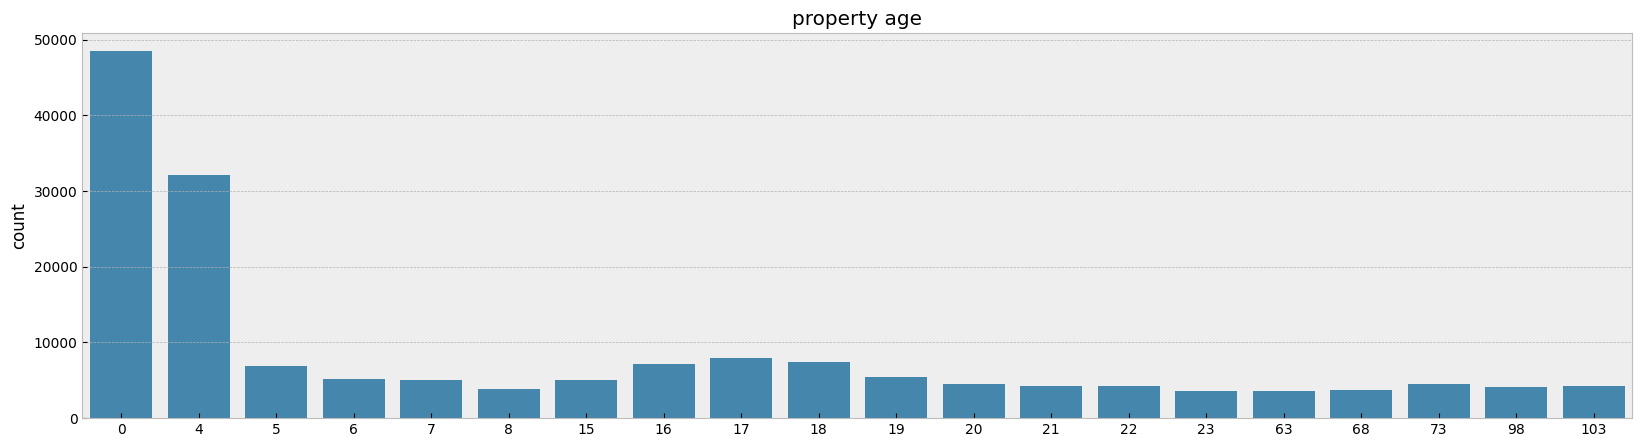

In [73]:
# заполняем пропуски настоящим годом, так как его вероятно не указали 
# потому что здание только что построено
hf_df['year built'] = (hf_df['year built']
                       .fillna('2023')
                       .astype(float))

# могут попасться значения из будущего - это тоже пропуски
better_data['property age'] = ((2023 - hf_df['year built'])
                               .apply(lambda x: -1 if x < 0 else x)
                               .astype(int))

show_barplot('property age', is_binary=False)

> Дома в данных либо совсем новые, либо построены 4 года назад. Также встречаются и очень старые здания, возрастом около века. 

#### *Год реконструкции*

Реконструкция влияет на цену, так как это дополнительные трудозатраты.

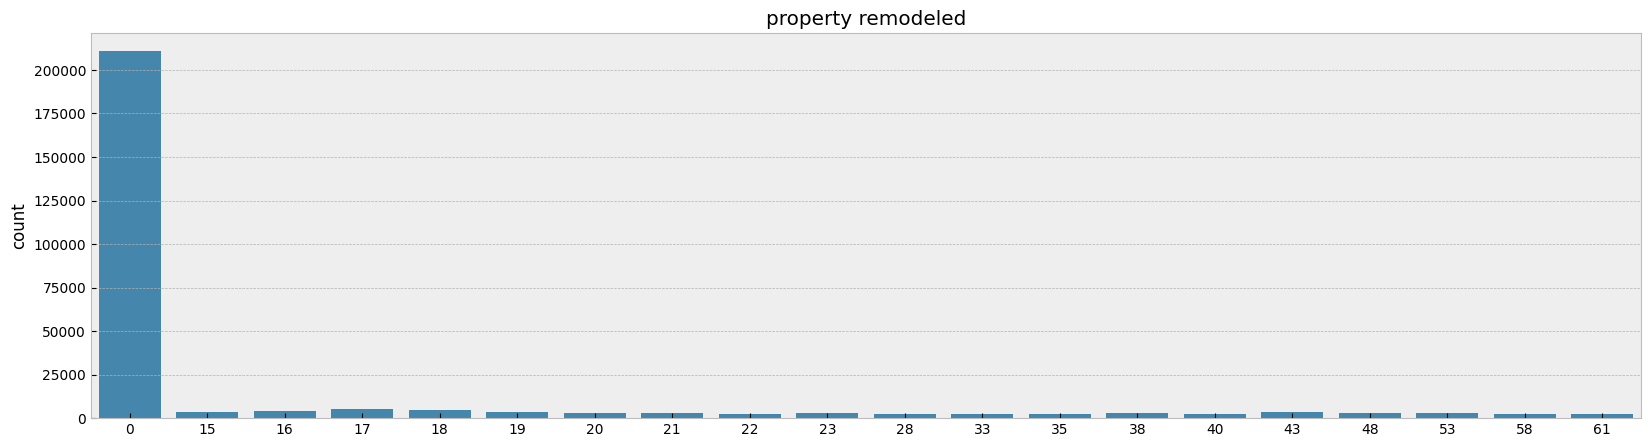

In [74]:
# делаем то же самое, что и с предыдущим признаком
hf_df['remodeled year'] = (hf_df['remodeled year']
                           .fillna('2023')
                           .astype(int))

better_data['property remodeled'] = 2023 - hf_df['remodeled year']
  

show_barplot('property remodeled', is_binary=False)

> Подавляющее большинство зданий не реконструировалось.

#### *Отопление*

In [75]:
get_populars(hf_df['heating'])

['forced air',
 nan,
 'other',
 'electric',
 'gas',
 'heat pump',
 'central air',
 'central electric',
 'central',
 'central, electric',
 'baseboard',
 'wall',
 'electric heat',
 'heating system',
 'forced air, heat pump',
 'radiant',
 'central air, ceiling fan(s)',
 'natural gas heat',
 'central furnace',
 'forced air, gas',
 'central electric, zoned',
 'forced air heating',
 ', gas hot air/furnace',
 'gas heat',
 'forced air, natural gas',
 'central heating',
 'central gas',
 'central electric, heat pump',
 ', heat pump - heat',
 'central air conditioning',
 'electric, gas',
 'forced air, other',
 'central, gas',
 'refrigeration',
 'central, electric, heat pump',
 'refrigeration, ceiling fan(s)',
 'oil',
 'central, heat pump',
 'forced air, stove',
 'central air, central heat',
 'natural gas',
 'heat pump(s)',
 ', gas hot air/furnace, multizone heat',
 'central, gas, two or more units',
 'electric, heat pump',
 'baseboard, forced air',
 'central, electric, two or more units',
 'force

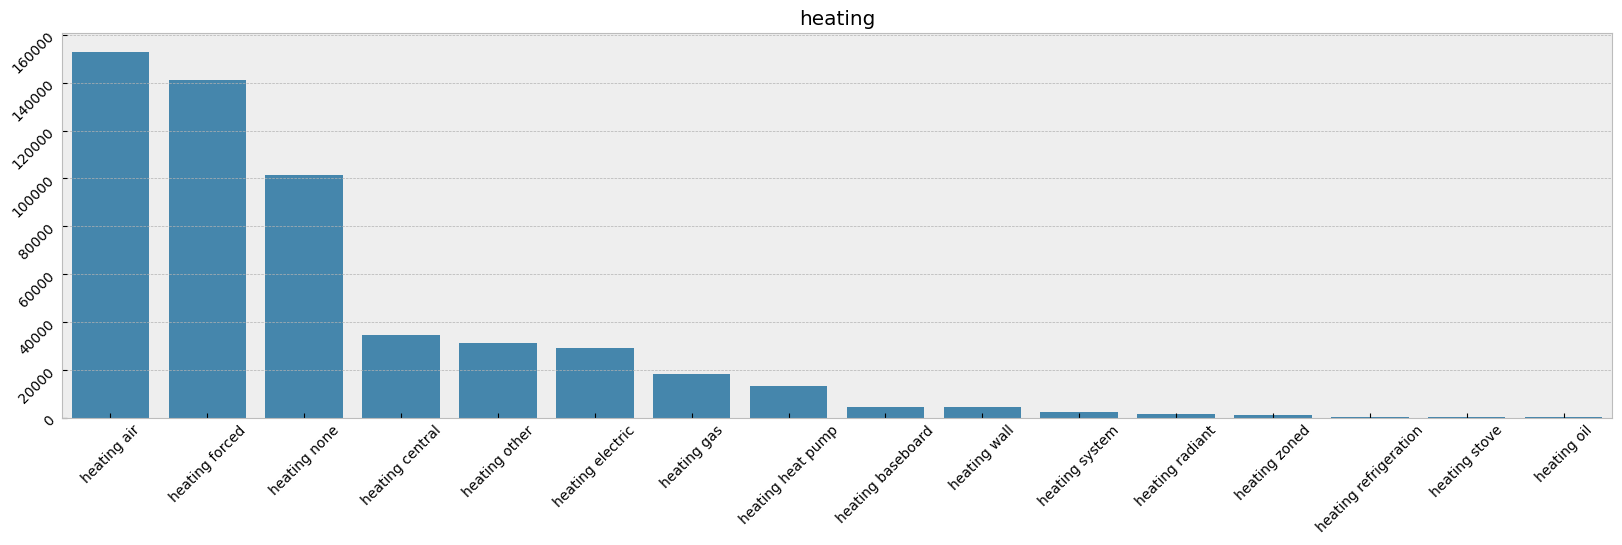

In [76]:
heatings = ['forced', 'air', 'none', 
            'electric', 'gas', 'heat pump', 
            'central', 'baseboard', 'wall', 
            'system', 'radiant', 'stove', 
            'zoned', 'refrigeration', 'oil']

# пропуски будем считать за отсутствующее отопление
hf_df['heating'].fillna('none', inplace=True)

better_data = get_dummy_features('heating', labels=heatings, data=hf_df)


show_barplot('heating')

> Дома имеют воздушное, центральное, электрическое или газовое отопление. Также многие дома не имеют отопления вообще.

#### *Охлаждение*

In [77]:
get_populars(hf_df['cooling'])

['central',
 nan,
 'central air',
 'has cooling',
 'none',
 'central electric',
 'wall',
 'central gas',
 'central heating',
 'cooling system',
 'central a/c',
 'other',
 'central a/c (electric), central heat (gas)',
 'central a/c (electric), central heat (electric)',
 'refrigeration',
 'central, electric',
 'evaporative',
 'electric',
 'central air, gas hot air/furnace',
 'refrigeration, ceiling fan(s)',
 'central gas, zoned',
 'central, wall',
 'air conditioning-central',
 '2 or more units, central, electric',
 'has heating',
 'central air, gas (hot air)',
 'central electric, zoned',
 'central air, zoned',
 'solar, refrigeration',
 'central, other',
 'ceiling fan, central electric',
 'central cooling',
 'electric heating',
 'heat pump',
 'gas heating',
 'central a/c (electric), central heat (gas), zoned',
 'central electric, heat pump',
 'gas heating, forced air heating',
 'heat pump - ac',
 'central air, gas hot air/furnace, multizone a/c',
 'central electric, central gas',
 'forced

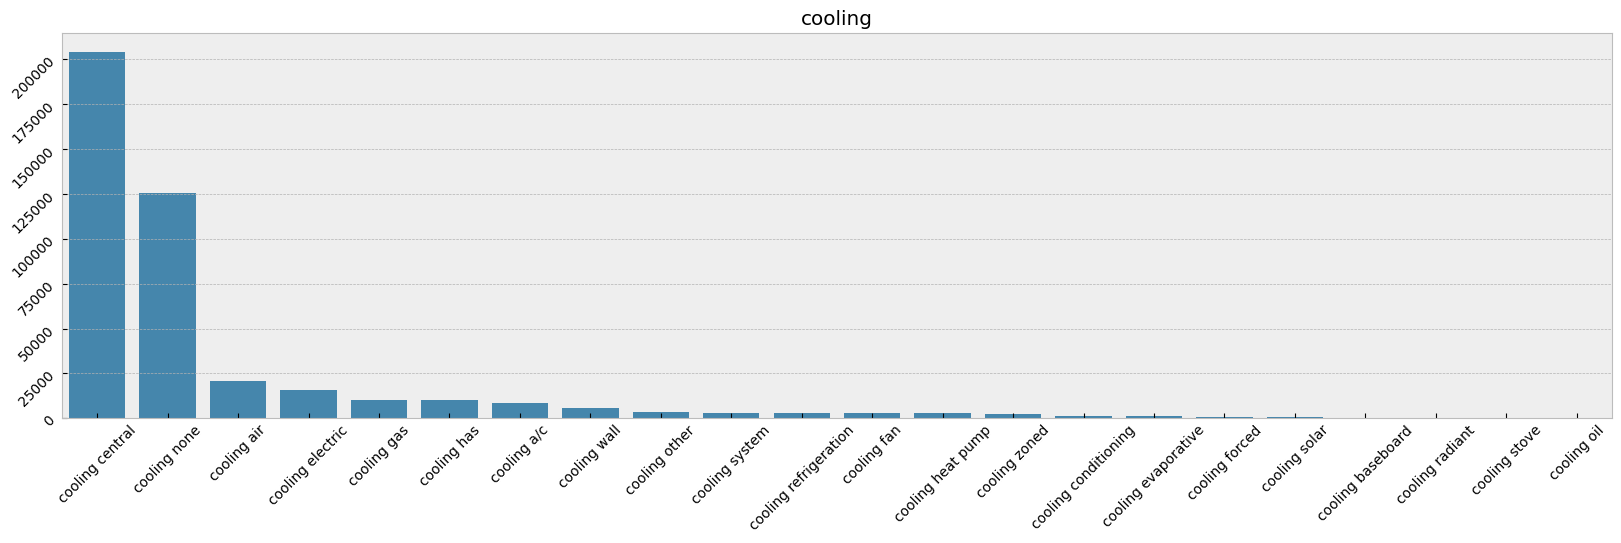

In [78]:
# охлаждение имеет те же типы, что и отопление, но с некоторыми новыми
coolings = heatings + ['has', 'a/c', 'evaporative', 
                       'fan', 'conditioning', 'solar']

hf_df['cooling'].fillna('none', inplace=True)

better_data = get_dummy_features('cooling', labels=coolings, data=hf_df)

show_barplot('cooling')

> Дома, в большинстве случаев, либо имеют центральное охлаждение, либо не имеют никакого. 

#### *Парковка*

Если в доме есть гараж или паркинг, то его жильцы могут себе позволить машину, и не одну. Следовательно на такие объекты можно ставить более высокую цену.

In [79]:
get_populars(hf_df['parking'])

[nan,
 'attached garage',
 '2 spaces',
 '1 space',
 'detached garage',
 'carport',
 'off street',
 '3 spaces',
 'carport, attached garage',
 '1',
 '4 spaces',
 '2',
 'none',
 'on street',
 'attached garage, detached garage',
 '0',
 'attached garage, carport',
 'parking desc',
 '6 spaces',
 'detached garage, attached garage',
 'driveway',
 '5 spaces',
 '4',
 'off street parking',
 'off street, attached garage',
 'parking type',
 '3',
 'carport, detached garage',
 'attached garage, garage - 2 car',
 'garage type',
 'parking yn',
 'off street, on street',
 'driveway, garage door opener',
 'garage - 2 car',
 'garage door opener',
 '888',
 'attached garage, off street',
 'off street, detached garage',
 'attached - front',
 'slab parking spaces',
 'detached garage, carport',
 '8 spaces',
 '6',
 'garage-attached',
 'electric door opener',
 'attached - side',
 'attached',
 'on street, off street',
 '7 spaces',
 'carport spaces',
 'electric door opener, slab parking spaces',
 'garage attached',

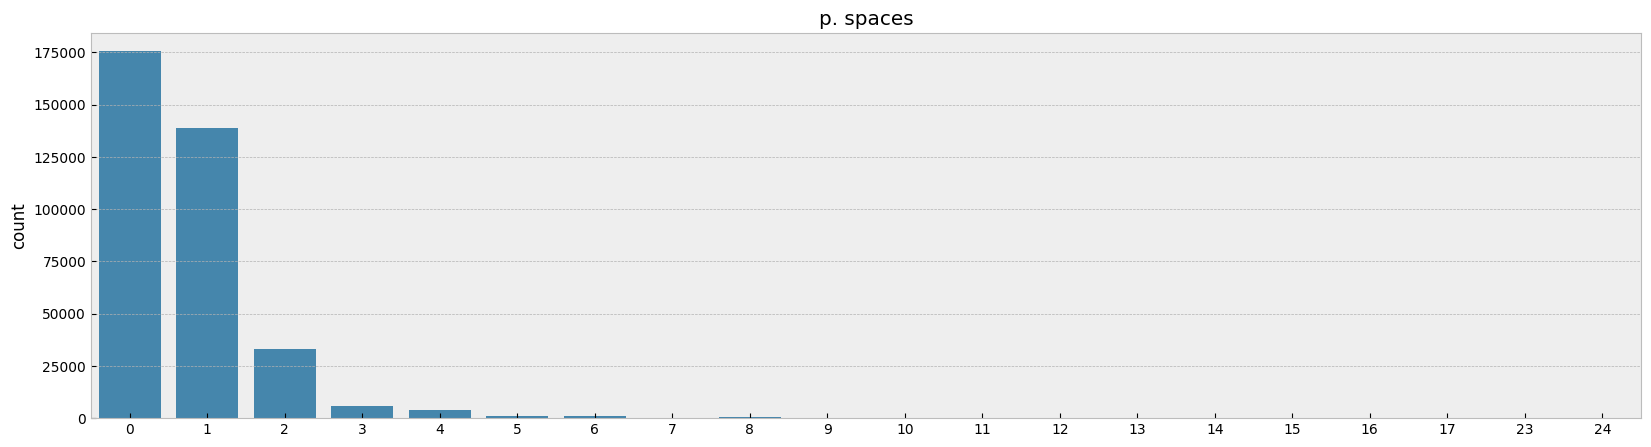

In [111]:
def get_spaces(x):      
    """ 
    Возвращает количество парковочных мест.
    """  
    xsplit = x.split()
    
    # если в получившемся списке есть только один элемент, 
    # и это пропуск или открыто указывается "нет", то мест 0
    if ((len(xsplit) == 1) and 
        (xsplit[0] == 'none') or 
        (xsplit[0] == 'no')):
        return 0
    
    # выделяем все числовые символы из строки - это и есть количества мест
    spaces_list = list(filter(lambda s: s.isnumeric(), x))
    
    # суммируем все указанные значения - именно столько мест находится возле дома
    if len(spaces_list) != 0:
        return sum(map(int, spaces_list))
    
    # в остальных случаях возле дома есть хотя бы 1 место
    return 1


hf_df['parking'].fillna('none', inplace=True)

better_data['p. spaces'] = hf_df['parking'].apply(get_spaces).astype(int)

show_barplot('p. spaces', is_binary=False)

> Объекты имеют либо 1-2 парковочных места, либо не имеют парковки рядом.

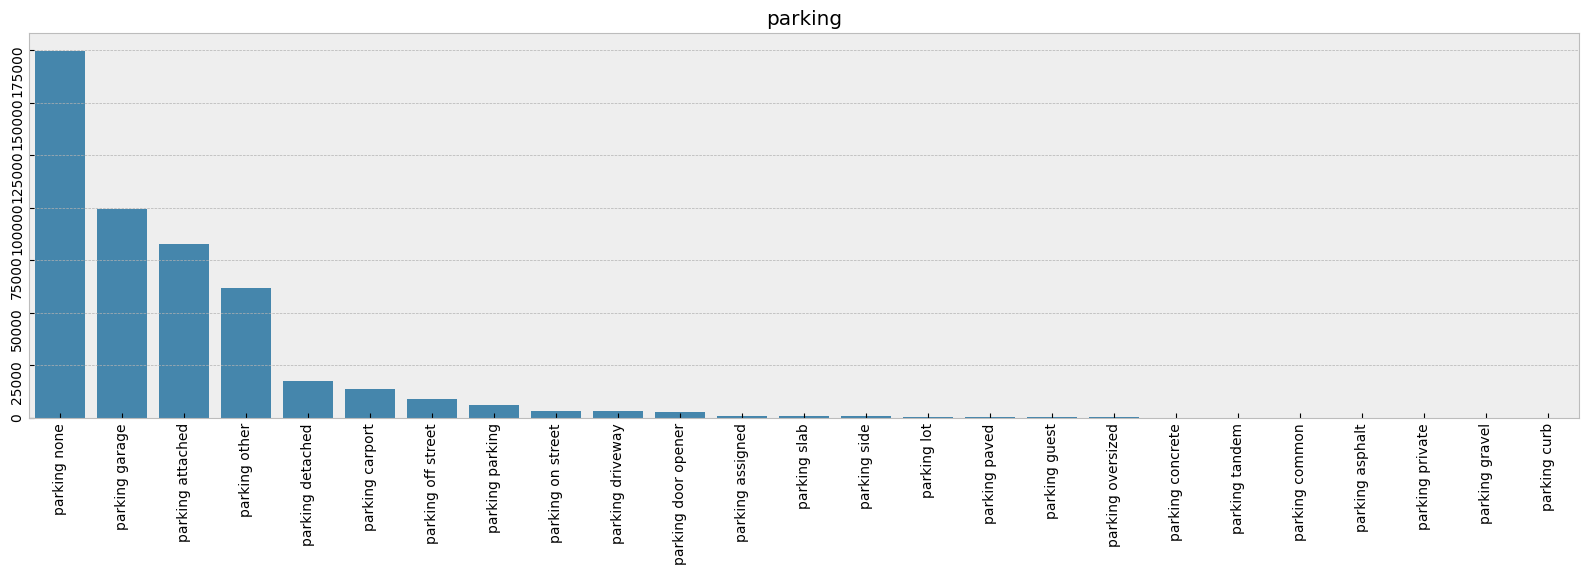

In [81]:
park_dict = {'drvwy': 'driveway', 
             'unassigned': '', 
             'aspht': 'asphalt', 
             'gravl': 'gravel', 
             'dw': 'driveway', 
             'onstr': 'on street', 
             'on-street': 'on street', 
             'pvt': 'paved', 
             'public': 'common', 
             'individual': 'private', 
             'concr': 'concrete'}

parkings = ['garage', 'attached', 'detached', 'parking', 
            'carport', 'off street', 'on street', 'door opener', 
            'driveway', 'lot', 'paved', 'slab', 
            'asphalt', 'gravel', 'common', 'side', 
            'concrete', 'curb', 'private', 'guest', 
            'oversized', 'assigned', 'tandem', 'none']

better_data = get_dummy_features('parking', 
                                 rep_dict=park_dict, 
                                 labels=parkings, 
                                 data=hf_df)


show_barplot('parking', rotation=90)

> Дома, которые имеют парковочные места, как правило имеют либо гараж, либо пристроенный паркинг (например подземный или в доме)

#### *Площадь участка*

Имеет то же значение, что и площадь дома. Если есть участок - это дополнительная площадь и повышение цены.

In [82]:
get_populars(hf_df['lotsize'])

[nan,
 '—',
 '-- sqft lot',
 '0.26 acres',
 '0.25 acres',
 '0.28 acres',
 '0.27 acres',
 '0.29 acres',
 '0.34 acres',
 '0.31 acres',
 '0.32 acres',
 '6,098 sqft',
 '0.3 acres',
 '0.33 acres',
 '7,405 sqft',
 '0.35 acres',
 '6,534 sqft',
 '4,356 sqft',
 '10,000 sqft',
 '0.46 acres',
 '0.36 acres',
 '5,227 sqft',
 '1 acre',
 '0.37 acres',
 '5,000 sqft',
 '8,712 sqft',
 '3,920 sqft',
 '8,276 sqft',
 '0.38 acres',
 '0.39 acres',
 '0.41 acres',
 '0.5 acres',
 '10019',
 '10,019 sqft',
 '10000',
 '0.42 acres',
 '4,792 sqft',
 '0.43 acres',
 '0.44 acres',
 '0.4 acres',
 '9,583 sqft',
 '4,791 sqft',
 '10,454 sqft',
 '2,500 sqft',
 '0.45 acres',
 '7,840 sqft',
 '3,049 sqft',
 '6,969 sqft',
 '0.48 acres',
 '0.47 acres',
 '7,500 sqft',
 '6,000 sqft',
 '0.30 acres',
 '0.52 acres',
 '2,000 sqft',
 '0.51 acres',
 '6,970 sqft',
 '5,662 sqft',
 '871 sqft',
 '10018 sqft',
 '7405',
 '3,485 sqft',
 '4,000 sqft',
 '0.49 acres',
 '7,841 sqft',
 '0.53 acres',
 '5,663 sqft',
 '10890',
 '7,501 sqft',
 '0.55 ac

> Площадь указывается либо в акрах, либо в квадратных футах.

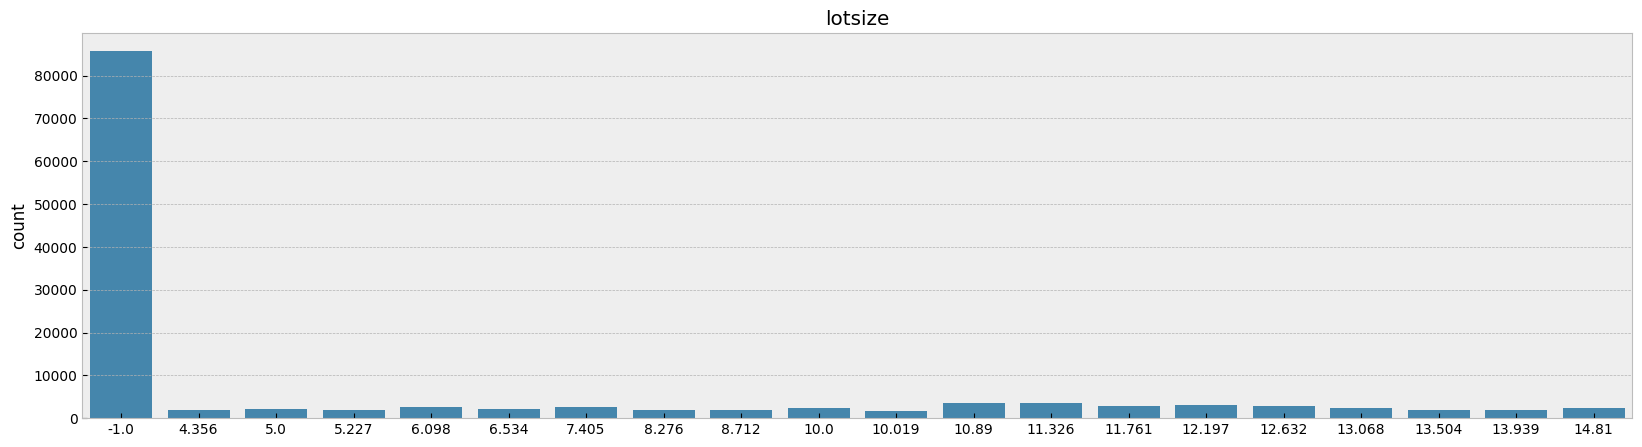

In [83]:
# приводим пропуски к единому стандарту
hf_df['lotsize'] = (hf_df['lotsize']
                    .fillna('--')
                    .apply(lambda x: 'none' 
                           if (('--' in x) or ('—' in x)) 
                           else x))


def get_lotsize(x):
    """ 
    Возвращает площадь участка в тыс. квадратных футах.
    """
    
    # убираем ненужную запятую и делим строку по пробелам
    xsplit = x.replace(',', '').split()
    
    # пропуск
    if xsplit[0] == 'none':
        return -1
    
    # если открыто указана в квадратных футах - возвращаем ее
    if ((('sqft' in xsplit) or 
         ('sq.' in xsplit) or 
         (len(xsplit) == 1) and (xsplit[0] != 'none'))):
        return float(xsplit[0])
    
    # переводим акры в квадратные футы
    if 'acres' in xsplit:
        acres = float(xsplit[0])
        return acres * 43560
    
    
# делим на 1000 для соблюдения масштаба
better_data['lotsize'] = (hf_df['lotsize']
                          .apply(get_lotsize)
                          .astype(float)
                          .apply(lambda x: round(x / 1000, 3) 
                                 if x > 0 
                                 else x))


show_barplot('lotsize', is_binary=False)

> Признак и его распределение очень похожи на признак площади дома, тут тоже очень много пропусков.

#### *Цена за квадратный фут*

Данный признак мы не рассматриваем, так как его добавление в датасет приведет к утечке данных.

### Почтовый индекс

Почтовый индекс, или зип-код, в США имеет следующую структуру:

На примере **12345**
- Цифра **1** - это группа штатов, всего их 9

<img src='img/zip-codes.png' width=500>

*Источник: https://unidedstateszipcodes.org*

- Цифры **23** - это район штата (на примере штата Огайо)

<img src='img/91GVhyTCBmL.jpg' width=500>

*Источник: https://www.amazon.com/Ohio-ZIP-Code-Map-Counties/dp/B09GZH9C9B*

- Цифры **45** - это район города, в котором находится почтовое отделение 
(на примере города Хьюстон)

<img src='img/Service-Area-Map.jpg' width=500>

*Источник: https://seniorridesandmore.org/?page_id=1230*

На мой взгляд, этот признак говорит нам намного больше, чем признак улицы дома, города и штата. Обработаем его.

*Я мог бы вычислить координаты каждого отдельного объекта с помощью `geopy` или `geopandas` и таким образом вычислить район, расстояние до центра и прочее, но сделать это практически невозможно, так как геолокатор все время выдавал ошибку "слишком много запросов". Поэтому я данный метод отклонил.*

In [84]:
data['zipcode'][:50]

0     28387
1     99216
2     90049
3     75205
4     32908
5     19145
6     34759
7     50401
8     77080
9     11354
10    77068
11    33028
12    97401
13    77084
14    11219
15    33311
16    10027
17    77375
18    33304
19    93552
20    97702
21    33139
22    77386
23    76542
24    20009
25    33183
26    77018
27    33328
28    11238
29    90016
30    33614
31    34952
32    33160
33    32210
34    28202
35    93705
36    33133
37    33610
38    75214
39    92127
40    33332
41    89108
42    91342
43    75709
44    76179
45    85310
46    32164
47    11357
48    33137
49    97221
Name: zipcode, dtype: object

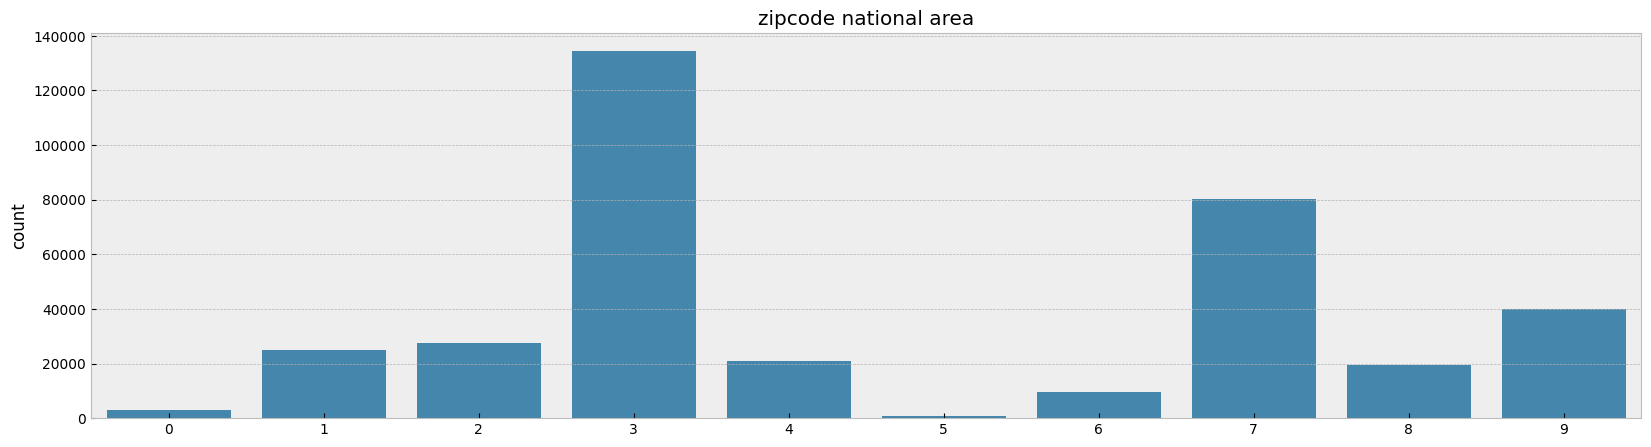

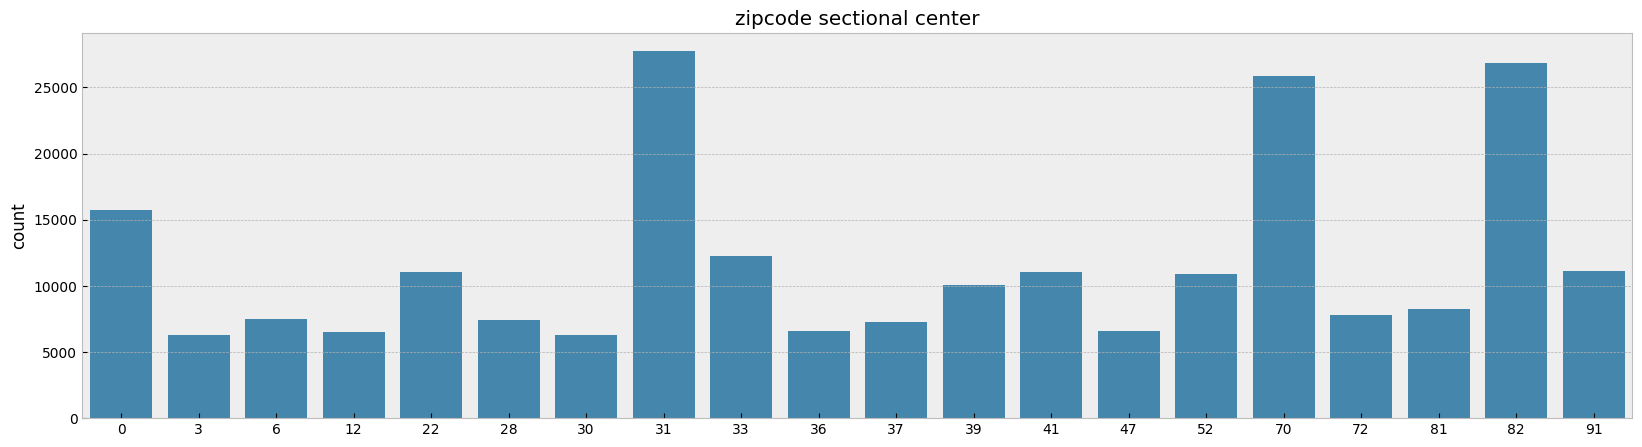

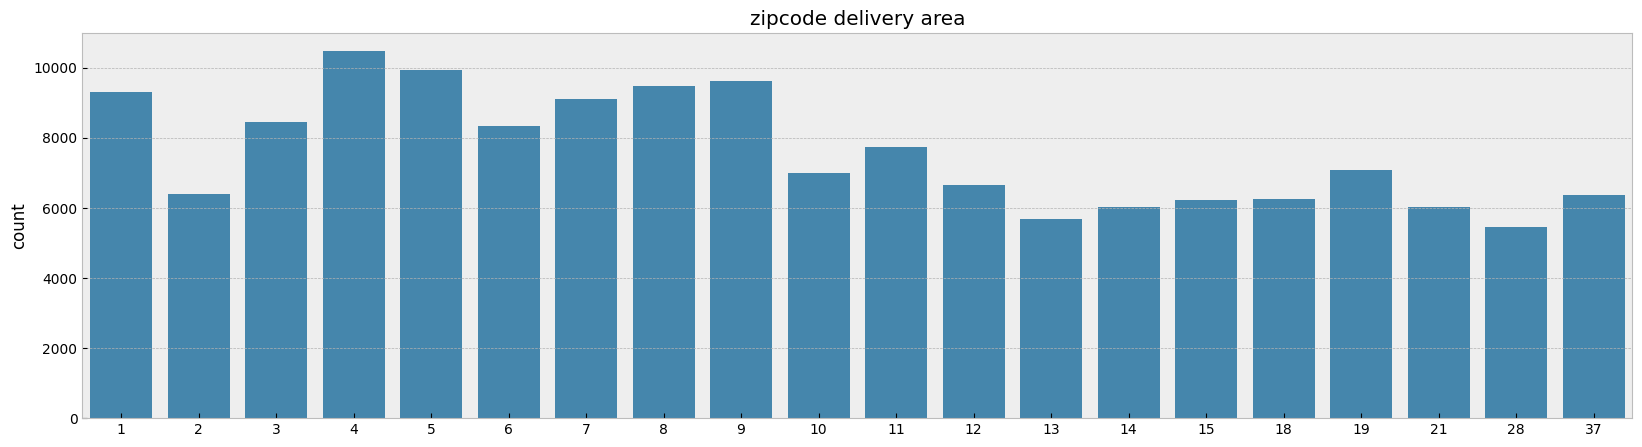

In [85]:
# в данных присутствуют и индексы в формате ZIP+4, но их очень мало, 
# так что приведем их к единому стандарту и заполним пропуски
data['zipcode'] = (data['zipcode']
                   .apply(lambda x: x[:5] if len(x) > 5 else x)
                   .apply(lambda x: '00000' 
                          if ((x == '--') or (len(x) != 5)) 
                          else x))

# группа штатов, район штата, район города
better_data['zipcode national area'] = data['zipcode'].apply(lambda x: int(x[0]))
better_data['zipcode sectional center'] = data['zipcode'].apply(lambda x: int(x[1:3]))
better_data['zipcode delivery area'] = data['zipcode'].apply(lambda x: int(x[3:]))


for code in ['zipcode national area', 
             'zipcode sectional center', 
             'zipcode delivery area']:
    show_barplot(code, is_binary=False)

> Объявления были собраны в основном из южных и западных штатов.

### Города

Интересен здесь даже не город сам по себе, а например, его размеры, так как в больших городах цены на недвижимость выше, чем в маленьких. Но для этого придется обратиться к сторонним источникам.

In [86]:
get_populars(data['city'])

['houston',
 'san antonio',
 'miami',
 'jacksonville',
 'dallas',
 'chicago',
 'orlando',
 'charlotte',
 'tampa',
 'brooklyn',
 'las vegas',
 'fort worth',
 'fort lauderdale',
 'nashville',
 'austin',
 'philadelphia',
 'cleveland',
 'washington',
 'los angeles',
 'seattle',
 'atlanta',
 'kissimmee',
 'ocala',
 'palm coast',
 'new york',
 'detroit',
 'indianapolis',
 'denver',
 'miami beach',
 'saint petersburg',
 'lehigh acres',
 'raleigh',
 'port charlotte',
 'portland',
 'el paso',
 'punta gorda',
 'chattanooga',
 'reno',
 'durham',
 'san diego',
 'lakewood',
 'cincinnati',
 'memphis',
 'knoxville',
 'cape coral',
 'glendale',
 'sacramento',
 'flushing',
 'college station',
 'hialeah',
 'fresno',
 'hollywood',
 'bronx',
 'doral',
 'staten island',
 'pensacola',
 'jamaica',
 'wilmington',
 'poinciana',
 'st petersburg',
 'clarksville',
 'panama city beach',
 'vancouver',
 'boston',
 'coral gables',
 'irvine',
 'laredo',
 'fayetteville',
 'lakeland',
 'mckinney',
 'lauderhill',
 'bonit

Файл с данными о каждом городе в США.

*Источник: https://simplemaps.com/data/us-cities*

In [87]:
cities = pd.read_csv('data/uscities.csv')

cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30844 entries, 0 to 30843
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          30844 non-null  object 
 1   city_ascii    30844 non-null  object 
 2   state_id      30844 non-null  object 
 3   state_name    30844 non-null  object 
 4   county_fips   30844 non-null  int64  
 5   county_name   30844 non-null  object 
 6   lat           30844 non-null  float64
 7   lng           30844 non-null  float64
 8   population    30844 non-null  int64  
 9   density       30844 non-null  float64
 10  source        30844 non-null  object 
 11  military      30844 non-null  bool   
 12  incorporated  30844 non-null  bool   
 13  timezone      30844 non-null  object 
 14  ranking       30844 non-null  int64  
 15  zips          30842 non-null  object 
 16  id            30844 non-null  int64  
dtypes: bool(2), float64(3), int64(4), object(8)
memory usage: 3.6+ MB


Нас интересуют только следующие столбцы: 
- `city`: название города
- `state_name`: название штата
- `population`: количество населения в городе
- `ranking`: "важность" города от 1 (самый важный) до 5 (не важный), что бы это ни значило

Файл с сокращениями названий штатов. Нужен потому что в основной таблице указаны именно сокращения, а в вышеуказанной - полные названия.

*Источник: https://github.com/jasonong/List-of-US-States/blob/master/states.csv*

In [88]:
states = pd.read_csv('data/states.csv')

states.head(10)

,State,Abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA
5,Colorado,CO
6,Connecticut,CT
7,Delaware,DE
8,District of Columbia,DC
9,Florida,FL


Тут структура понятна: 
- `State`: название штата
- `Abbreviation`: сокращение

In [89]:
# выделяем интересующие нас столбцы
cities_df = cities[['city', 'state_name', 'population', 'ranking']]

# заполняем пропуски и приводим строки к нижнему регистру
for col in cities_df.columns:
    if cities_df[col].dtype == 'object':
        cities_df[col] = fix_feature(cities_df[col])

# то же самое с сокращениями
for col in states.columns:
    states[col] = fix_feature(states[col])

# соединяем обе таблицы по признаку названия штата
cities_df = pd.merge(cities_df, 
                     states, 
                     how='left', 
                     left_on='state_name', 
                     right_on='State')

# переименуем для удобства
cities_df['state_name'] = cities_df['Abbreviation']

# выкидываем ненужное
cities_df = (cities_df
             .drop(['State', 'Abbreviation'], axis=1)
             .dropna(axis=0))

cities_df

,city,state_name,population,ranking
0,new york,ny,18972871,1
1,los angeles,ca,12121244,1
2,chicago,il,8595181,1
3,miami,fl,5711945,1
4,dallas,tx,5668165,1
...,...,...,...,...
30839,ironville,pa,0,3
30840,newkirk,nm,0,3
30841,falcon village,tx,0,3
30842,hidden lakes,oh,0,3


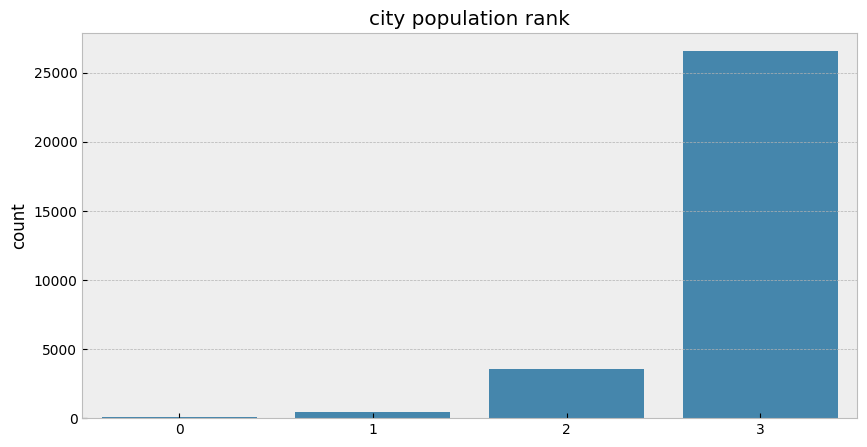

In [90]:
def get_population_rank(x):
    """
    Возвращает уровень популяции:\n
    0 - город миллионник\n
    1 - крупный город\n
    2 - средний город\n
    3 - маленькие городки, ПГТ и деревни
    """
    if x > 1e6:
        return 0
    
    if 1e6 > x > 1e5:
        return 1
    
    if 1e5 > x > 1e4:
        return 2
    
    if 1e4 > x:
        return 3
    
cities_df['city population rank'] = cities_df['population'].apply(get_population_rank)


show_barplot('city population rank', 
             data=cities_df, 
             is_binary=False, 
             figsize=(10, 5)) 

> Крупных городов всегда меньше, чем мелких, несмотря на то, что США - урбанизованная страна и большинство населения живет в городах.

In [91]:
# переименовываем некоторые столбцы, удаляем ненужный и дубликаты, чтобы не мешали
cities_df.rename(columns={'ranking': 'city importance', 
                          'state_name': 'state'}, 
                 inplace=True)
cities_df.drop('population', axis=1, inplace=True)
cities_df.drop_duplicates(inplace=True)

cities_df

,city,state,city importance,city population rank
0,new york,ny,1,0
1,los angeles,ca,1,0
2,chicago,il,1,0
3,miami,fl,1,0
4,dallas,tx,1,0
...,...,...,...,...
30839,ironville,pa,3,3
30840,newkirk,nm,3,3
30841,falcon village,tx,3,3
30842,hidden lakes,oh,3,3


In [92]:
# соединяем получившиеся столбцы с основной таблицей, 
# чтобы потом добавить их в итоговый датасет по индексам
cities_df = pd.merge(data[['city', 'state']], 
                     cities_df, 
                     how='left', 
                     on=['city', 'state']).fillna(-1) 

cities_df 

,city,state,city importance,city population rank
0,southern pines,nc,3.0,2.0
1,spokane valley,wa,2.0,1.0
2,los angeles,ca,1.0,0.0
3,dallas,tx,1.0,0.0
4,palm bay,fl,2.0,1.0
...,...,...,...,...
360187,washington,dc,1.0,0.0
360188,miami,fl,1.0,0.0
360189,chicago,il,1.0,0.0
360190,jamaica,ny,-1.0,-1.0


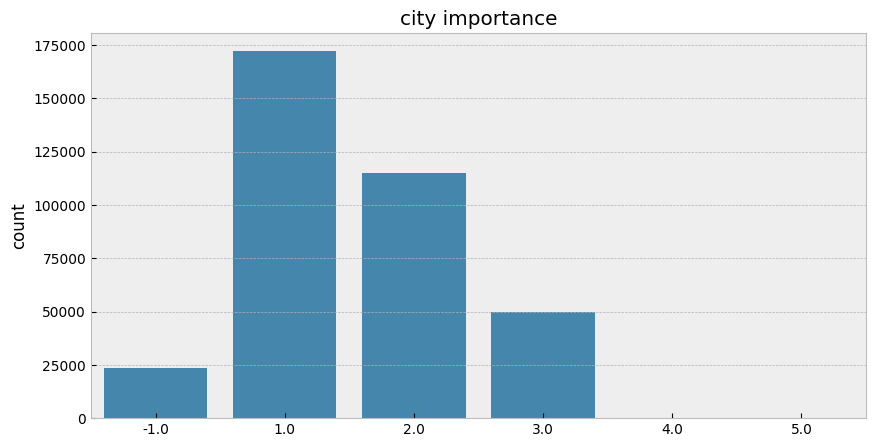

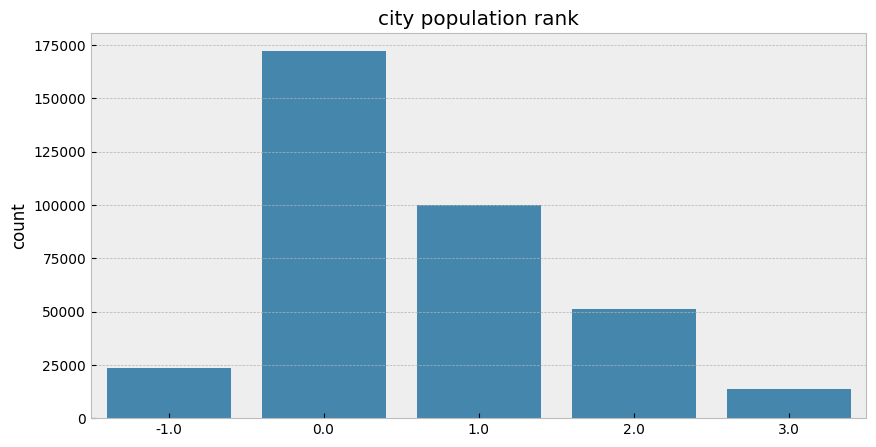

In [93]:
# добавляем нужные столбцы в нашу таблицу
city_labels = ['city importance', 'city population rank']

better_data[city_labels] = cities_df[city_labels]

# удаляем использованные таблицы за ненадобностью и для экономии памяти
del cities, states, cities_df

for label in city_labels:
    show_barplot(label, is_binary=False, figsize=(10, 5))

> Данные в основном собраны из крупных и очень крупных городов. Можно заметить, что два графика совпадают, что может говорить о сильной корреляции.

### Школы

Этот признак будет интересен семьям с детьми. Тем более количество и характеристики школ влияет на цену также как метро, тороговые центры, больницы и прочая инфраструктура рядом с домом.

По структуре похож на признак с Фактами, это словари со списками. Распакуем их.

In [94]:
data['schools']

0         [{'rating': ['4', '4', '7', 'nr', '4', '7', 'n...
1         [{'rating': ['4/10', 'none/10', '4/10'], 'data...
2         [{'rating': ['8/10', '4/10', '8/10'], 'data': ...
3         [{'rating': ['9/10', '9/10', '10/10', '9/10'],...
4         [{'rating': ['4/10', '5/10', '5/10'], 'data': ...
                                ...                        
360187    [{'rating': ['3/10', '3/10'], 'data': {'distan...
360188    [{'rating': ['10/10', '5/10'], 'data': {'dista...
360189    [{'rating': ['1/10', '5/10', '7/10'], 'data': ...
360190    [{'rating': ['5/10', '4/10'], 'data': {'distan...
360191    [{'rating': ['5/10', '4/10', '3/10'], 'data': ...
Name: schools, Length: 360192, dtype: object

In [95]:
# унифицируем пропуски
schools = data['schools'].apply(lambda x: x.replace('none, ', "'none', "))


# читаем словари и добавляем в новый список
schools_list = []

for school in schools:
    schools_le = ast.literal_eval(school)[0]
    schools_list.append(schools_le)

# вытаскиваем информацию о расстоянии и уровнях образования 
# в отдельные ключи и удаляем ненужный ключ из словарей
for schooldict in schools_list:
    schooldict['distance'] = schooldict['data']['distance']
    schooldict['grades'] = schooldict['data']['grades']
    
    del schooldict['data']

# обрабатываем пропуски
for schooldict in schools_list:
    for k, v in schooldict.items():
        if len(v) == 0:
            v.append('none')
        for elem in v:
            if elem == '':
                elem = 'none'


# данные о школах
schools_df = pd.DataFrame(schools_list)

schools_df 

,rating,name,distance,grades
0,"[4, 4, 7, nr, 4, 7, nr, nr]","[southern pines elementary school, southern mi...","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","[3–5, 6–8, 9–12, pk–2, 6–8, 9–12, pk–5, k–12]"
1,"[4/10, none/10, 4/10]","[east valley high school&extension, eastvalley...","[1.65mi, 1.32mi, 1.01mi]","[9-12, 3-8, pk-8]"
2,"[8/10, 4/10, 8/10]","[paul revere middle school, brentwood science ...","[1.19mi, 2.06mi, 2.63mi]","[6-8, k-5, 9-12]"
3,"[9/10, 9/10, 10/10, 9/10]","[mcculloch intermediate school, bradfield elem...","[1.05mi, 0.1mi, 1.05mi, 0.81mi]","[5-6, pk-4, 7-8, 9-12]"
4,"[4/10, 5/10, 5/10]","[southwest middle school, bayside high school,...","[5.96mi, 3.25mi, 3.03mi]","[7-8, 9-12, pk-6]"
...,...,...,...,...
360187,"[3/10, 3/10]","[garrison elementary school, cardozo education...","[0.4 mi, 0.1 mi]","[pk-5, 6-12]"
360188,"[10/10, 5/10]","[air base elementary school, dr michael m. kro...","[32.1 mi, 1.1 mi]","[pk-8, 9-12]"
360189,"[1/10, 5/10, 7/10]","[hope college prep high school, lake view high...","[10.61mi, 1.42mi, 0.4mi]","[9-12, 9-12, pk-8]"
360190,"[5/10, 4/10]","[ps 48 william wordsworth, jhs 8 richard s gro...","[0.48mi, 0.73mi]","[pk-5, 6-8]"


Структура данных следующая (каждый признак содержит список из отдельных значений): 
- `rating`: рейтинги школ от 1 до 10 
- `name`: названия школ
- `distance`: расстояние от дома до каждой школы
- `grades`: уровни образования в каждой школе

#### *Рейтинг школы*

In [96]:
schools_df['rating']

0         [4, 4, 7, nr, 4, 7, nr, nr]
1               [4/10, none/10, 4/10]
2                  [8/10, 4/10, 8/10]
3           [9/10, 9/10, 10/10, 9/10]
4                  [4/10, 5/10, 5/10]
                     ...             
360187                   [3/10, 3/10]
360188                  [10/10, 5/10]
360189             [1/10, 5/10, 7/10]
360190                   [5/10, 4/10]
360191             [5/10, 4/10, 3/10]
Name: rating, Length: 360192, dtype: object

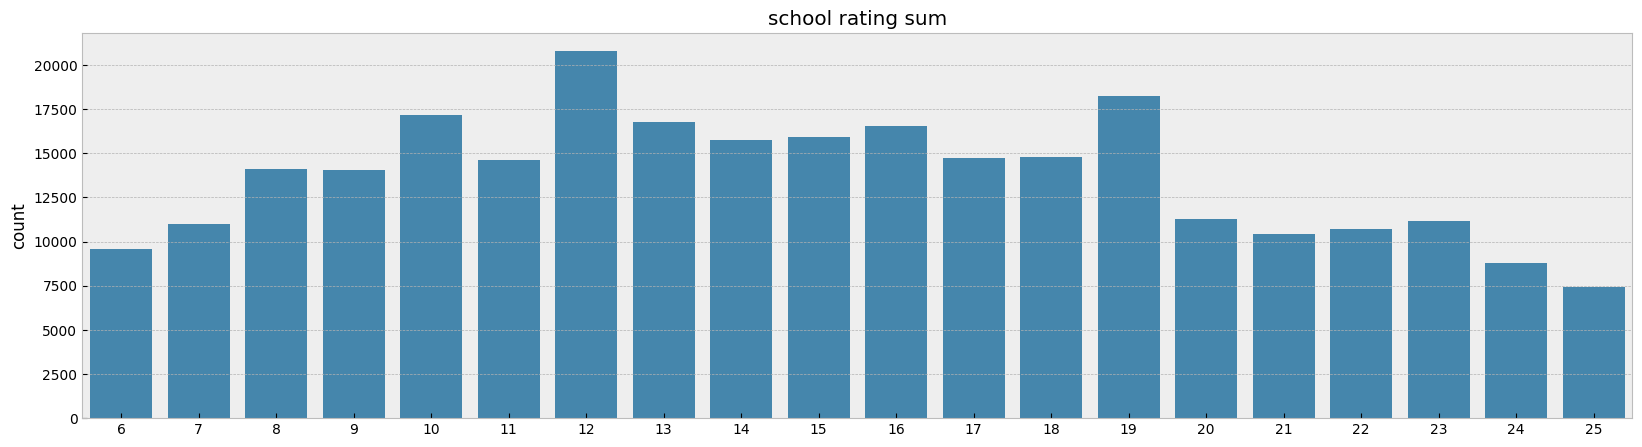

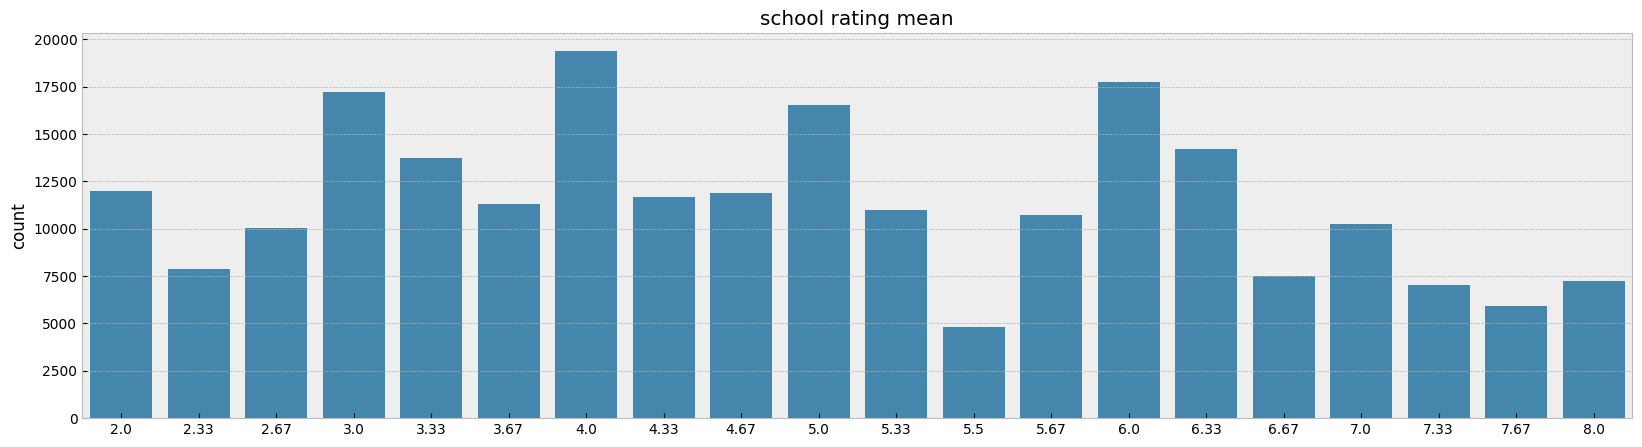

In [97]:
# обрабатываем пропуски
ratings = (schools_df['rating']
           .apply(lambda x: ['-1'] if x[0] == '' else x)
           .apply(lambda x: [int(xs
                                 .replace('/10', '')
                                 .replace('-', '-1')
                                 .replace('none', '-1')
                                 .replace('nr', '-1')
                                 .replace('na', '-1')
                                 .replace('-11', '-1')) 
                             for xs in x]))

# чем выше рейтинги в сумме и в среднем, тем выше цена
better_data['school rating sum'] = ratings.apply(lambda x: np.sum(x))
better_data['school rating mean'] = ratings.apply(lambda x: np.mean(x).round(2))


for rating in ['school rating sum', 'school rating mean']:
    show_barplot(rating, is_binary=False)

> На первом графике можно увидеть очертания некоторого "холма", где большая часть значений разбросана от 10 до 19, что слегка напоминает нормальное распределение

#### *Расстояние до школы*

Чем ближе школа к дому, тем выше цена, также как и прочая инфраструктура. 

In [98]:
schools_df['distance']

0         [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...
1                                  [1.65mi, 1.32mi, 1.01mi]
2                                  [1.19mi, 2.06mi, 2.63mi]
3                           [1.05mi, 0.1mi, 1.05mi, 0.81mi]
4                                  [5.96mi, 3.25mi, 3.03mi]
                                ...                        
360187                                     [0.4 mi, 0.1 mi]
360188                                    [32.1 mi, 1.1 mi]
360189                             [10.61mi, 1.42mi, 0.4mi]
360190                                     [0.48mi, 0.73mi]
360191                             [0.3 mi, 1.1 mi, 4.1 mi]
Name: distance, Length: 360192, dtype: object

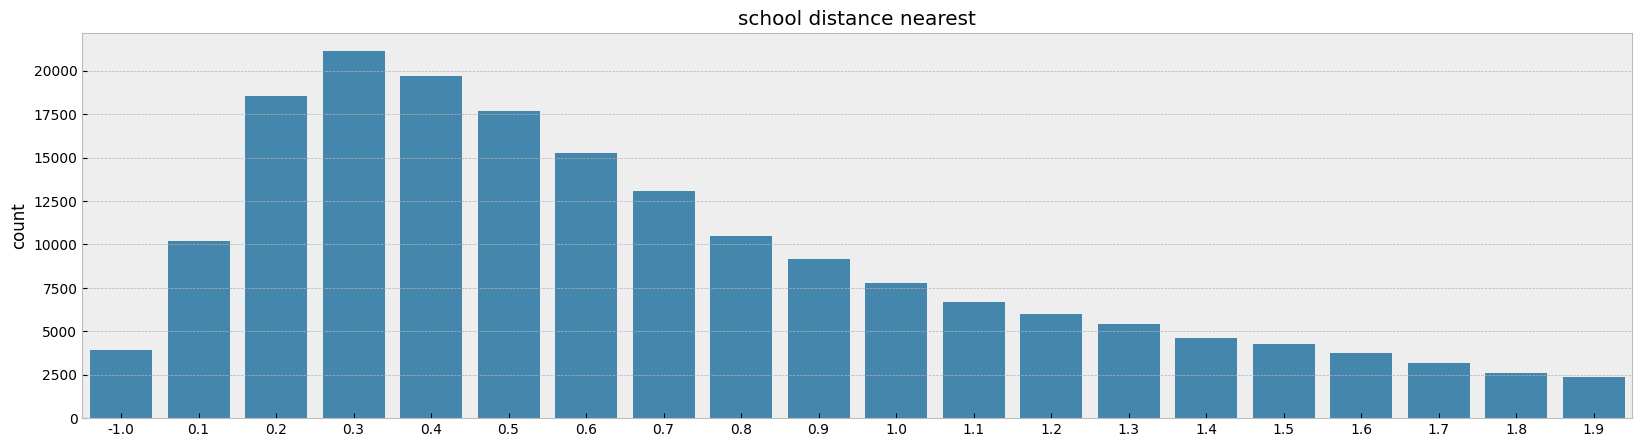

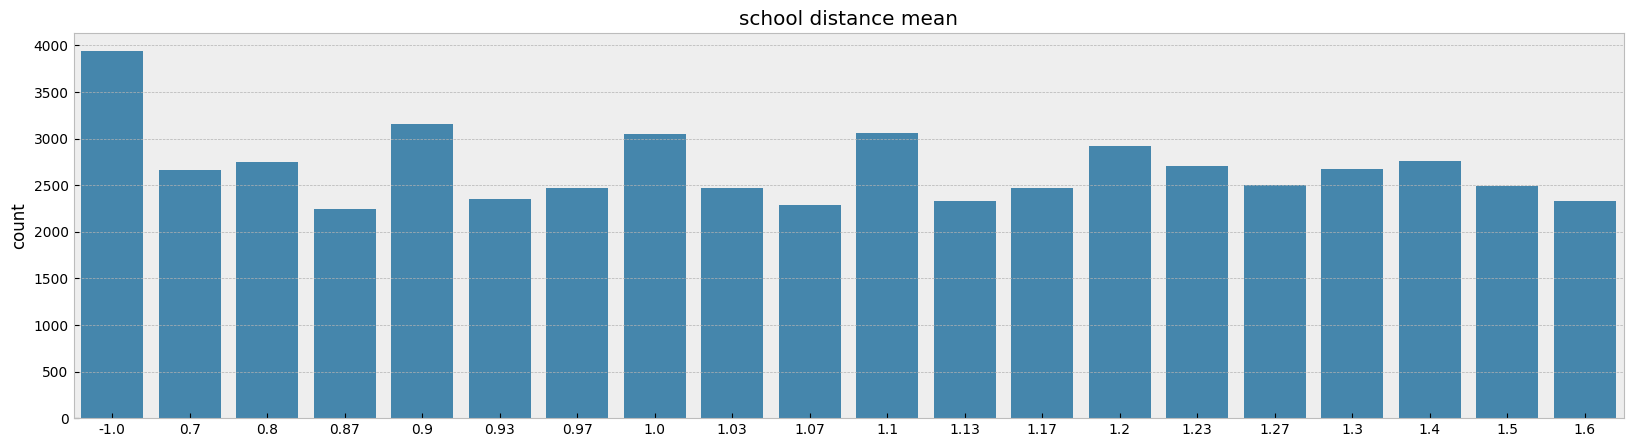

In [99]:
# обрабатываем признак
distance = schools_df['distance'].apply(lambda x: [float(xs
                                                         .replace('none', '-1')
                                                         .replace(' ', '')
                                                         .replace('mi', '')) 
                                                   for xs in x])

# расстояние до ближайшей школы и среднее расстояние (в милях)
better_data['school distance nearest'] = distance.apply(lambda x: np.min(x))
better_data['school distance mean'] = distance.apply(lambda x: np.mean(x).round(2))


for dist in['school distance nearest', 'school distance mean']:
      show_barplot(dist, is_binary=False)

> Первый график показывает четкое распределение значений. По нему можно построить коробчатую диаграмму, где сам ящик будет находиться в диапазоне от 0.2 до 0.6, а остальное - усы ящика. 

А тут я решил взять такие признаки как рейтинг лучшей школы в округе и расстояние до самой лучшей школы. 

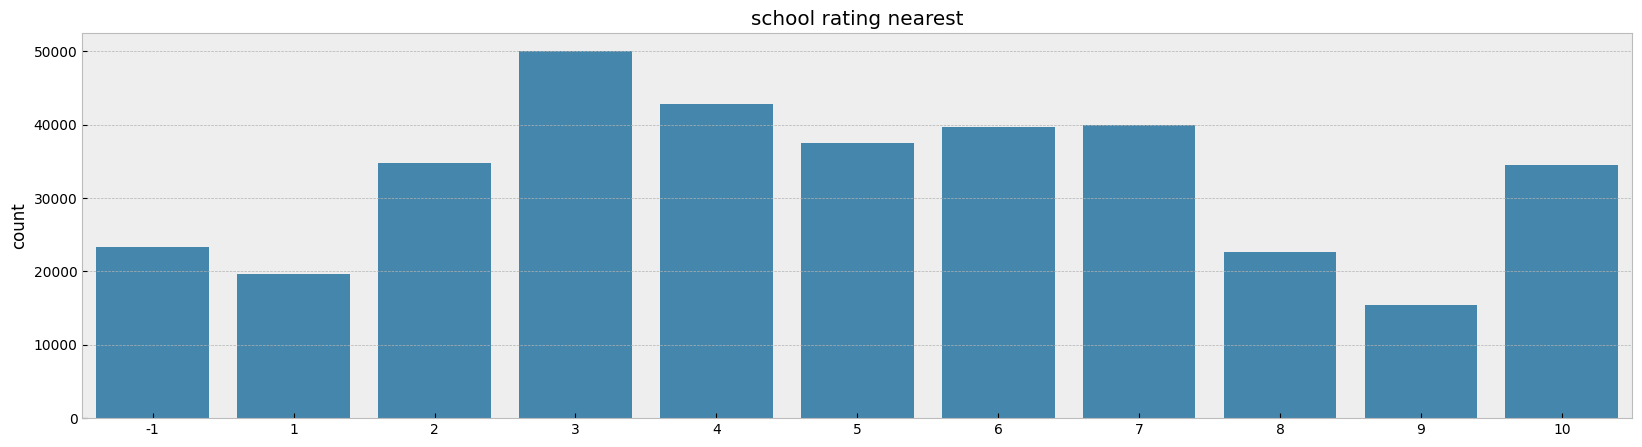

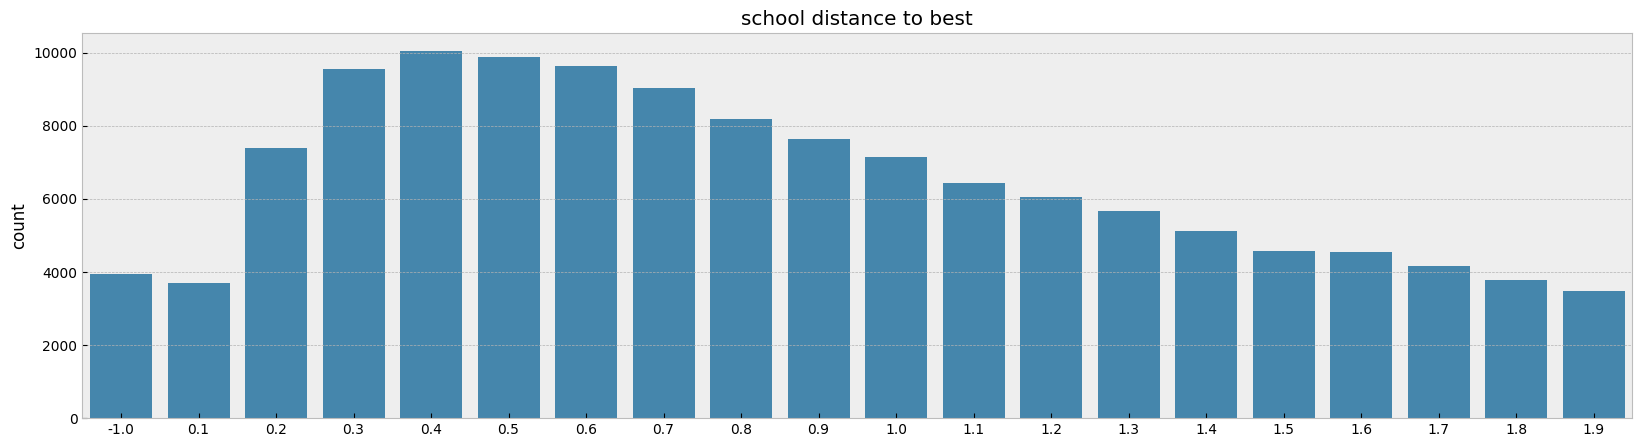

In [100]:
best = []
nearest = []

for i in data.index:
    # составляем дата-фрейм из рейтингов и расстояний всех школ
    rd_df = pd.DataFrame({'r': ratings[i], 'd': distance[i]})
    
    # сортируем и выделяем сначала рейтинг ближайшей, 
    # а затем расстояние до лучшей и добавляемв списки
    rat_n = rd_df.sort_values('d', ascending=False).iloc[0, 0]
    best.append(rat_n)
    
    dist_b = rd_df.sort_values('r', ascending=False).iloc[0, 1]
    nearest.append(dist_b)

# получившиеся списки - теперь столбцы
better_data['school rating nearest'] = best
better_data['school distance to best'] = nearest

for val in ['school rating nearest', 'school distance to best']:
    show_barplot(val, is_binary=False)

> На первом графике видно, что самые близкие к дому школы имеют средний рейтинг. А распределение второго графика похоже на распределение, графика расстояния до ближайшей школы, тоже возможна сильная корреляция.

#### *Уровни образования*

Этот признак говорит от том, есть ли в школе детский сад, система дошкольного обучения и сколько классов в ней можно проучиться. То есть это объективный уровень школы, на кого она рассчитана.

In [101]:
schools_df['grades']

0         [3–5, 6–8, 9–12, pk–2, 6–8, 9–12, pk–5, k–12]
1                                     [9-12, 3-8, pk-8]
2                                      [6-8, k-5, 9-12]
3                                [5-6, pk-4, 7-8, 9-12]
4                                     [7-8, 9-12, pk-6]
                              ...                      
360187                                     [pk-5, 6-12]
360188                                     [pk-8, 9-12]
360189                               [9-12, 9-12, pk-8]
360190                                      [pk-5, 6-8]
360191                                [pk-5, 6-8, 9-12]
Name: grades, Length: 360192, dtype: object

In [102]:
# надо привести некоторые символы к единому стандарту
grades = schools_df['grades'].apply(lambda x: [(xs
                                                .replace(' to ', '-')
                                                .replace('–', '-')
                                                .replace('na', 'none') 
                                                .replace('n/a', 'none')) 
                                               for xs in x])

# выделим все категории школ и посмотрим, какие существуют в принципе
grades_set = set()

for grs in grades:
    for g in grs:
        grades_set.add(g)
        
grades_set

{'1-1',
 '1-10',
 '1-11',
 '1-12',
 '1-2',
 '1-3',
 '1-4',
 '1-5',
 '1-6',
 '1-7',
 '1-8',
 '1-9',
 '10-10',
 '10-11',
 '10-12',
 '11-11',
 '11-12',
 '12',
 '12-12',
 '2-11',
 '2-12',
 '2-2',
 '2-3',
 '2-4',
 '2-5',
 '2-6',
 '2-7',
 '2-8',
 '2-9',
 '3',
 '3-10',
 '3-11',
 '3-12',
 '3-4',
 '3-5',
 '3-5, 10',
 '3-6',
 '3-7',
 '3-8',
 '4-10',
 '4-11',
 '4-12',
 '4-4',
 '4-5',
 '4-6',
 '4-7',
 '4-8',
 '4-9',
 '5',
 '5-10',
 '5-11',
 '5-12',
 '5-5',
 '5-6',
 '5-7',
 '5-8',
 '5-9',
 '6',
 '6-10',
 '6-11',
 '6-12',
 '6-6',
 '6-7',
 '6-8',
 '6-8, 10',
 '6-9',
 '7',
 '7-10',
 '7-11',
 '7-12',
 '7-7',
 '7-8',
 '7-9',
 '8',
 '8-10',
 '8-11',
 '8-12',
 '8-8',
 '8-9',
 '9',
 '9-10',
 '9-11',
 '9-12',
 '9-9',
 'k',
 'k-1',
 'k-1, 3-5',
 'k-10',
 'k-11',
 'k-12',
 'k-2',
 'k-3',
 'k-4',
 'k-4, 6-12',
 'k-4, 6-8',
 'k-5',
 'k-6',
 'k-6, 8',
 'k-7',
 'k-8',
 'k-8, 10',
 'k-9',
 'k-k',
 'none',
 'pk, 1, 5',
 'pk, 1-4',
 'pk, 1-5',
 'pk, 1-6',
 'pk, 2',
 'pk, 3-5',
 'pk, 5-8',
 'pk, 6-8',
 'pk, 9-12',
 '

> В США существует 12-классовая система школьного образования. Обозначения: "k" - это детский сад (от слова "kindergarten"), "pk" - это детский сад для детей до 5 лет (от слова "pre-kindergarten"), "preschool" - это курсы для подготовки к школе. Будем считать, что любое из этих обозначений - это как еще один, "нулевой", класс в школе.

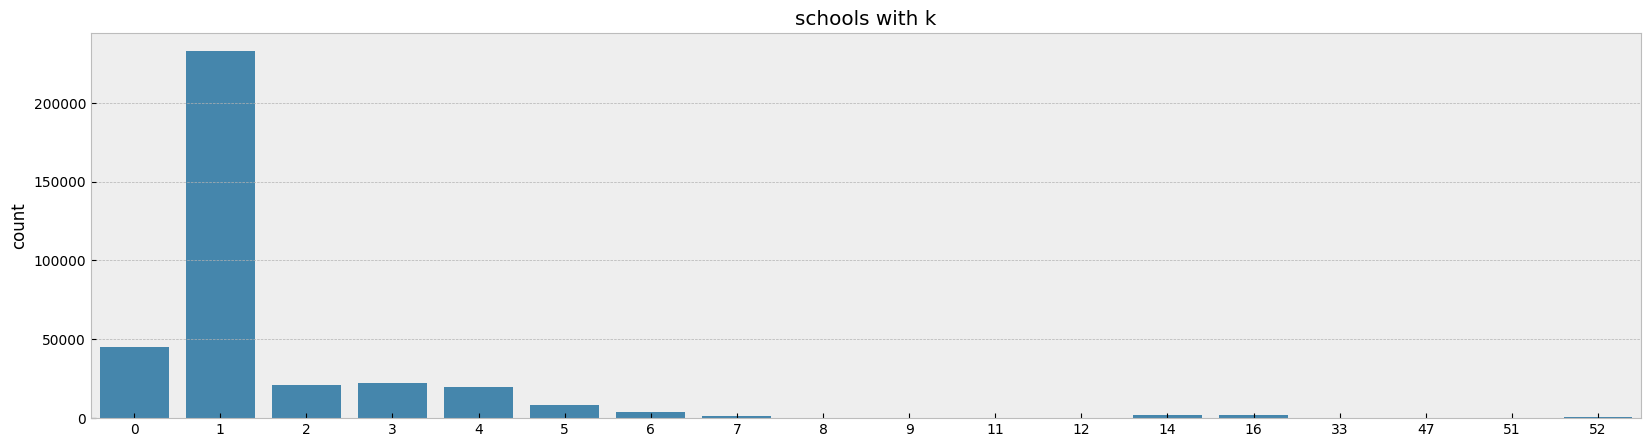

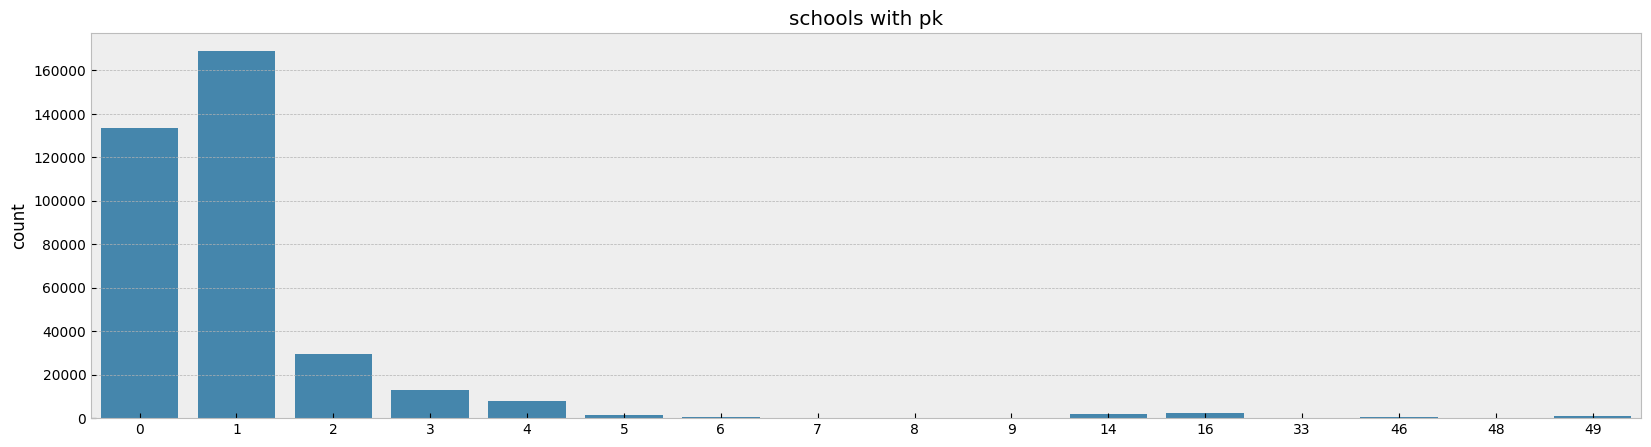

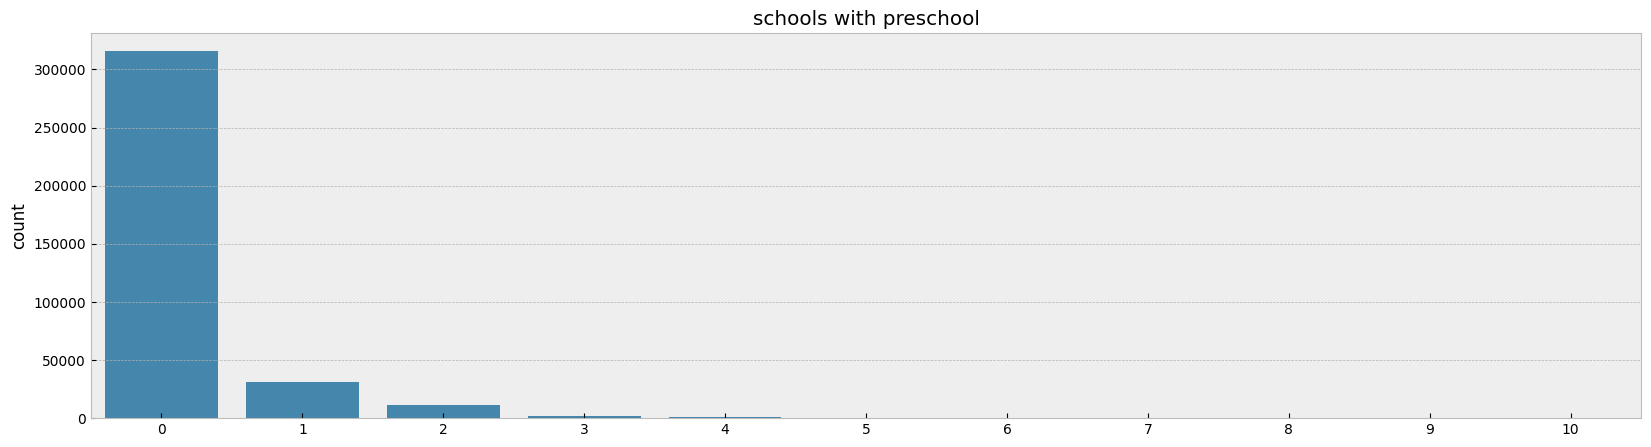

In [110]:
# создаем бинарные переменные, указывающие, 
# сколько школ в районе имеют сервисы для дошкольников 
g_types = ['k', 'pk', 'preschool']

for t in g_types:
    better_data['schools with '+t] = (grades
                                      .apply(lambda x: sum([1 if t in xs else 0 
                                                            for xs in x]))
                                      .astype('uint8'))
    
    show_barplot('schools with '+t, is_binary=False)

> Школы чаще всего имеют 1 садик, 1 садик для детей до 5 лет или не имеют, и не имеют дошкольных курсов.

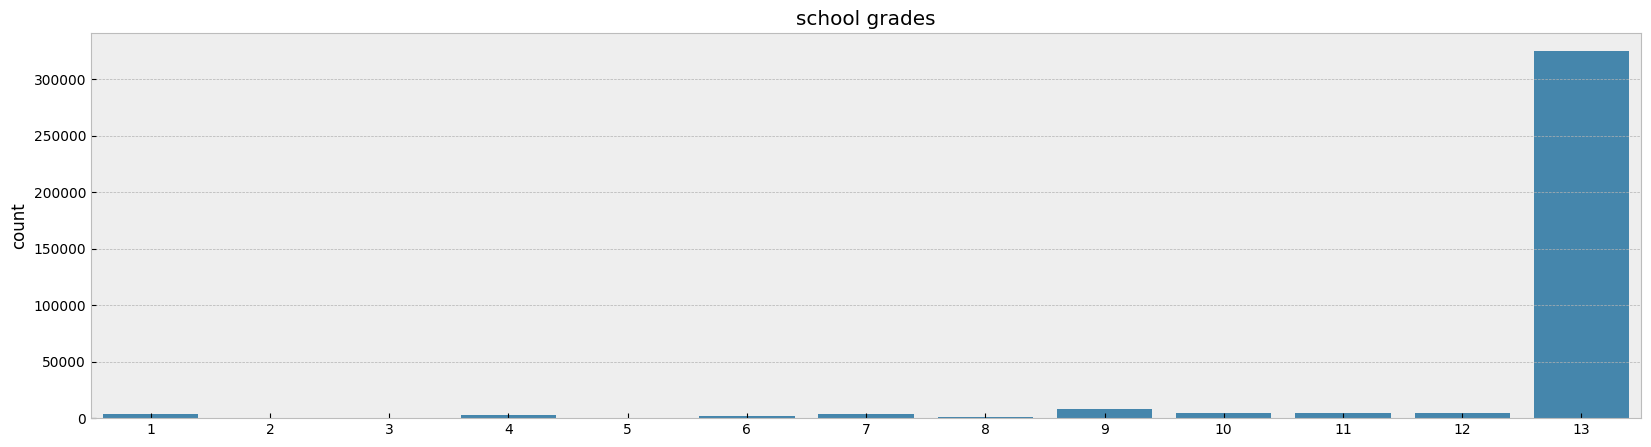

In [104]:
def get_grades(x): 
    """
    Возвращает количество классов в каждой школе.
    """
    
    # 1. Рассмотрим значения с запятыми, типа "pk-4, 6, 11". 
    # Разделим их по запятым и добавим каждый элемент в список, 
    # чтобы получилось ['pk-4', '6', '11']
    xnew = []
    
    for item in x:
        if ',' in item:
            item_splitted = item.split(', ')
            
            for splitted in item_splitted:
                xnew.append(splitted)
        
        else:
            xnew.append(item)
    
    # 2. Рассмотрим значения через тире. 
    # Разделим их по тире и добавим в новый список, 
    # чтобы получилось ['pk', '4', '6', '11']
    xnew2 = []
    
    for item in xnew:
        if '-' in item:
            item_splitted = item.split('-')
            
            # по сути значения с тире - это диапазон от начального класса к конечному, 
            # так что возьмем все классы в нем с помощью `range()` и добавим в общий список
            xrange = range(int(item_splitted[0]), 
                           int(item_splitted[-1])+1)
            
            for g in xrange:
                xnew2.append(g)
        
        else:
            xnew2.append(int(item))
    
    # количество уникальных элементов в получившемся списке 
    # - и есть количество классов в школе 
    return len(set(xnew2))

# заменим все дошкольные опции на "нулевой" класс
better_data['school grades'] = (grades
                                .apply(lambda x: [(xs
                                                   .replace('preschool', '0')
                                                   .replace('pk', '0')
                                                   .replace('k', '0')
                                                   .replace('none', '0'))
                                                   for xs in x])
                                .apply(get_grades))


show_barplot('school grades', is_binary=False)

> Подавляющее большинство школ предостваляют полное образование с дестского сада по 12 класс (система k-12).

### Цена недвижимости (целевой признак) 

Данный признак нужно привести в удобный вид, чтобы дальше с ним работать.

In [105]:
data['target'][:50]

0       $418,000
1       $310,000
2     $2,895,000
3     $2,395,000
4         $5,000
5       $209,000
6        181,500
7       $244,900
8       $311,995
9       $669,000
10       260,000
11      $525,000
12      $499,900
13      $168,800
14     1,650,000
15       335,000
16     2,650,000
17      $365,000
18      $626,000
19      $375,000
20    $3,500,000
21       579,000
22      $499,007
23      $182,000
24    $3,749,000
25       799,000
26      $499,900
27      $559,000
28      $830,000
29    $1,195,000
30      $262,000
31      $204,800
32      $179,000
33      $105,000
34      $260,000
35      $284,900
36      $495,000
37      $117,900
38      $385,000
39    $1,100,000
40      $620,000
41      $125,000
42      $499,000
43    $1,429,000
44     $233,990+
45      $275,000
46       $27,000
47      $598,000
48    $1,780,000
49      $490,000
Name: target, dtype: object

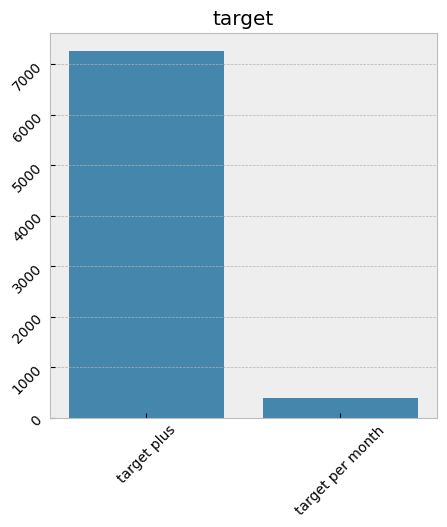

In [106]:
# иногда продавец указывает цену в месяц или 
# помечает ее плюсом, указывая, что она может быть больше.
better_data['target per month'] = (data['target']
                                   .apply(lambda x: 1 if '/mo' in x else 0)
                                   .astype('uint8'))

better_data['target plus'] = (data['target']
                              .apply(lambda x: 1 if '+' in x else 0)
                              .astype('uint8'))


show_barplot('target', figsize=(5, 5))

> Несмотря на то, что цену в месяц указывают очень редко, данный признак убирать не будем, так как он должен показать, почему цена указана ниже обычного.

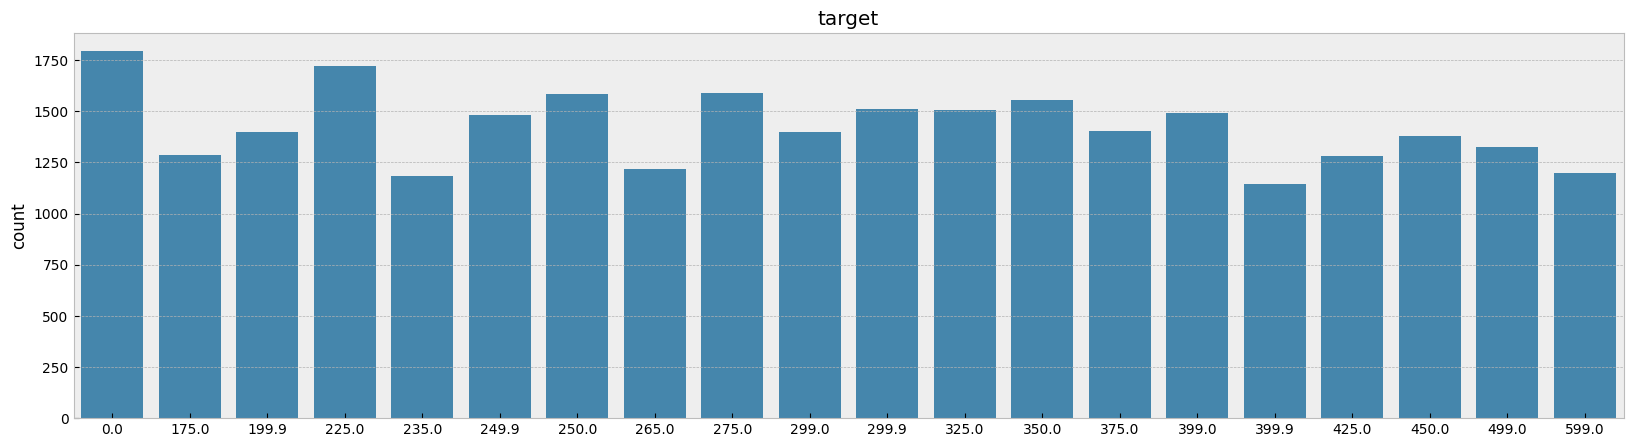

In [107]:
def get_target(x):
    """
    Возвращает целевой признак цены на недвижимость 
    в тыс. долларов США.
    """
    # убираем ненужные символы
    t_dict = {'$': ',', 
              ',': '/mo', 
              '/mo': '+', 
              '+': ''}
    
    for k, v in t_dict.items():
        x = x.replace(k, v)

    # если цена неизвестна, пусть она будет равна нулю
    if x == 'unknown':
        return 0
    
    # встретилось одно значение с тире, пусть это будет среднее 
    if '-' in x:
        xsplit = list(map(int, x.split(' - ')))
        x = np.mean(xsplit)
    
    return int(x) / 1000


better_data['target'] = data['target'].apply(get_target).round(3)

show_barplot('target', is_binary=False)

## **Загрузка обработанных признаков в отдельный датасет**

Обработку признаков можно считать завершенной, но далее предстоит еще Разведвыательный анализ и Машинное обучение. Этот ноутбук итак слишком большой, поэтому я решил разделить работу на две части. Первая - Обработка данных, которая была проделана только что. Вторая - Разведвыательный анализ и Машинное обучение, которые требуют не меньше времени и сил. 

In [108]:
# удаляем первоначальную таблицу и загружаем готовую таблицу в CSV-файл
better_data.to_csv('data/data_edited.csv', index=False)
del data

better_data

,status for sale,status coming soon,status new,status foreclosure,status pre-foreclosure,status pending,status auction,status active,status show,status for rent,...,school distance mean,school rating nearest,school distance to best,schools with k,schools with pk,schools with preschool,school grades,target per month,target plus,target
0,0,0,0,0,0,0,0,1,0,0,...,5.54,7,5.10,3,2,0,13,0,0,418.000
1,1,0,0,0,0,0,0,0,0,0,...,1.33,4,1.65,1,1,0,13,0,0,310.000
2,1,0,0,0,0,0,0,0,0,0,...,1.96,8,1.19,1,0,0,13,0,0,2895.000
3,1,0,0,0,0,0,0,0,0,0,...,0.75,9,1.05,1,1,0,13,0,0,2395.000
4,1,0,0,0,0,0,0,0,0,0,...,4.08,4,3.25,1,1,0,13,0,0,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360187,1,0,0,0,0,0,0,0,0,0,...,0.25,3,0.40,1,1,0,13,0,0,799.000
360188,0,0,0,0,0,0,0,0,0,0,...,16.60,10,32.10,1,1,0,13,0,0,1249.000
360189,1,0,0,0,0,0,0,0,0,0,...,4.14,1,0.40,1,1,0,13,0,0,674.999
360190,1,0,0,0,0,0,0,0,0,0,...,0.60,4,0.48,1,1,0,9,0,0,528.000


*Смотрите продлжение работы в файле `modeling_nb.ipynp`*